<a href="https://colab.research.google.com/github/Renata1027/Mathematical-modeling/blob/main/2_IBM_%E7%A6%BB%E8%81%8C%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.线性回归
线性回归用于建立自变量（X）和因变量（y）之间的线性关系模型：

**核心公式：**

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n$  

* $\hat{y}$：预测值

* $\beta_0$：截距（y轴交点）

* $\beta_1, \beta_2, \ldots, \beta_n$：自变量的系数

* $x_1, x_2, \ldots, x_n$：特征变量

**目标：最小化残差平方和（RSS）**

$\min_{\beta} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$

* $m$ 是样本数量。

**系数求解（正规方程）**

$\boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

* $\boldsymbol{\beta}$：系数向量 $[\beta_0, \beta_1, \ldots, \beta_n]^T$

* $\mathbf{X}$：包含全1列的特征矩阵（形状 $m \times (n+1)$）

* $\mathbf{y}$：目标值向量（形状 $m \times 1$）

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

### 1.1数据加载

In [2]:
fp = '/content/IBM_HR_Analytics.csv'
ibmdata = pd.read_csv(fp,index_col = 0)

In [ ]:
print(ibmdata.describe())

         DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000       1470.000000  1470.000000         1470.0   
mean    802.485714          9.192517     2.912925            1.0   
std     403.509100          8.106864     1.024165            0.0   
min     102.000000          1.000000     1.000000            1.0   
25%     465.000000          2.000000     2.000000            1.0   
50%     802.000000          7.000000     3.000000            1.0   
75%    1157.000000         14.000000     4.000000            1.0   
max    1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335                 1.093082    20.329428        0.711561   
min          1.000000                 1.000000    30.000000        1.00

In [3]:
print(f"缺失值统计:\n{ibmdata.isnull().sum().sort_values(ascending=False)}")

缺失值统计:
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
Yea

In [4]:
target = 'MonthlyIncome'
x = ibmdata.drop(columns=[target])
y = ibmdata[target]

In [5]:
print(ibmdata.dtypes)

Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYea

### 1.2数据预处理

In [6]:
# 特征类型识别
def identify_feature_types(df,unique_threshold=15):
  numeric_features = []
  categorical_features = []
  categoricals = [
        'Attrition','BusinessTravel',
        'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'OverTime',
        'Over18',
  ]
  numeric_categoricals = [
        'Education', 'EnvironmentSatisfaction',
        'JobInvolvement', 'JobLevel',
        'JobSatisfaction', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel',
        'WorkLifeBalance'
  ]

  for col in df.columns:
    if col in categoricals:
      categorical_features.append(col)
      continue
    if col in numeric_categoricals:
      categorical_features.append(col)
      continue
    else:
      numeric_features.append(col)
  return numeric_features,categorical_features

In [7]:
numeric_features, categorical_features = identify_feature_types(x)

In [8]:
print(f"连续数值型特征 ({len(numeric_features)}): {numeric_features}")
print(f"分类特征 ({len(categorical_features)}): {categorical_features}")

连续数值型特征 (15): ['DailyRate', 'DistanceFromHome', 'EmployeeCount', 'EmployeeNumber', 'HourlyRate', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
分类特征 (18): ['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']


**Onehot 特征处理**

* 分类变量（如"红色"、"蓝色"）不能直接用于数学计算

* 避免模型错误理解类别顺序（如将"高/中/低"编码为1/2/3会引入虚假顺序关系）

**核心原理**

假设特征有 k 个类别，则创建 k 个新二进制特征列：


* 每个类别对应一列


* 样本属于某类别时，该列=1，其他列=0


In [9]:
# 数据预处理管道
preprocessor = ColumnTransformer(
    transformers = [
        ('num',StandardScaler(),numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ]
)

In [10]:
# 划分数据集
x_train,x_test,y_train,y_test = train_test_split(
    x,y,test_size = 0.2,random_state = 42
)
target_var = "MonthlyIncome"
if target_var in numeric_features:
    numeric_features.remove(target_var)

### 1.3特征选择

In [ ]:
# 多重共线性检测（only numeric_features）
def calculate_vif(df,features,threshold = 5):
  if not features:
    return []
  vif_data = pd.DataFrame()
  vif_data['feature'] = features
  try:
    vif_data['VIF'] = [variance_inflation_factor(df[features].values, i)
                        for i in range(len(features))]
  # 完整vif
    print("\n所有特征的VIF值:")
    print(vif_data.sort_values("VIF", ascending=False))
  except Exception as e:
    print(f"计算错误: {e}")
    vif_data["VIF"] = np.nan
  high_vif = vif_data[vif_data['VIF'] > threshold].dropna()
  if not high_vif.empty:
    print("\n高VIF特征（多重共线性风险）:")
    print(high_vif.sort_values("VIF", ascending=False))
  return list(high_vif["feature"])
high_vif_features = calculate_vif(x_train,numeric_features)


所有特征的VIF值:
                    feature       VIF
11           YearsAtCompany  4.549694
12       YearsInCurrentRole  2.732775
14     YearsWithCurrManager  2.605077
9         TotalWorkingYears  2.038147
13  YearsSinceLastPromotion  1.605594
6        NumCompaniesWorked  1.231360
1          DistanceFromHome  1.011823
0                 DailyRate  1.011486
5               MonthlyRate  1.009592
3            EmployeeNumber  1.008784
10    TrainingTimesLastYear  1.008242
7         PercentSalaryHike  1.008186
4                HourlyRate  1.005370
2             EmployeeCount  0.000000
8             StandardHours  0.000000


RandomForestRegressor: 用于回归任务的随机森林模型

n_estimators=200: 使用200棵决策树（树越多通常效果越好，但计算成本更高）

random_state=42: 设置随机种子保证结果可复现

oob_score=True: 启用袋外（Out-of-Bag）误差估计（一种内置的交叉验证方式）

In [11]:
# 特征重要性分析
rf = RandomForestRegressor(n_estimators=200,random_state=42,oob_score=True)
rf_pipeline = Pipeline(
    steps = [
        ('preprocessor',preprocessor),
        ('regressor',rf)
    ]
)
rf_pipeline.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DailyRate',
                                                   'DistanceFromHome',
                                                   'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'HourlyRate', 'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'StandardHours',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'Year...
                                                   'BusinessTravel',
                                                   'Department', 'Education',
                                                   'EducationField',
                                                   'EnvironmentSatisfaction',
                                                   'Gender', 'JobInvolvement',
                                                   'JobLevel', 'JobRole',
                                                   'JobSatisfaction',
                                                   'MaritalStatus', 'Over18',
                                                   'OverTime',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'WorkLifeBalance'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, oob_score=True,
                                       random_state=42))])

Pipeline: 将多个处理步骤封装为单一对象

第一步：'preprocessor' - 数据预处理

第二步：'regressor' - 随机森林回归模型

In [12]:
# 获取特征名称
cat_encoder = preprocessor.named_transformers_['cat'] # preprocessor 管道提取'cat'的分类特征转换器
if hasattr(cat_encoder,'get_feature_names_out'): # 现代方法：如果编码器有get_feature_names_out()方法（scikit-learn >= 1.0）
  cat_features = cat_encoder.get_feature_names_out(categorical_features) #获取编码后的特征名（如gender_Female, gender_Male）
else: #旧方法
  cat_features = [f'cat_{i}' for i in range(len(cat_encoder.categorical_features_))]
all_features = numeric_features + list(cat_features)

In [13]:
print(all_features)

['DailyRate', 'DistanceFromHome', 'EmployeeCount', 'EmployeeNumber', 'HourlyRate', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'Education_2', 'Education_3', 'Education_4', 'Education_5', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'EnvironmentSatisfaction_2', 'EnvironmentSatisfaction_3', 'EnvironmentSatisfaction_4', 'Gender_Male', 'JobInvolvement_2', 'JobInvolvement_3', 'JobInvolvement_4', 'JobLevel_2', 'JobLevel_3', 'JobLevel_4', 'JobLevel_5', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director'

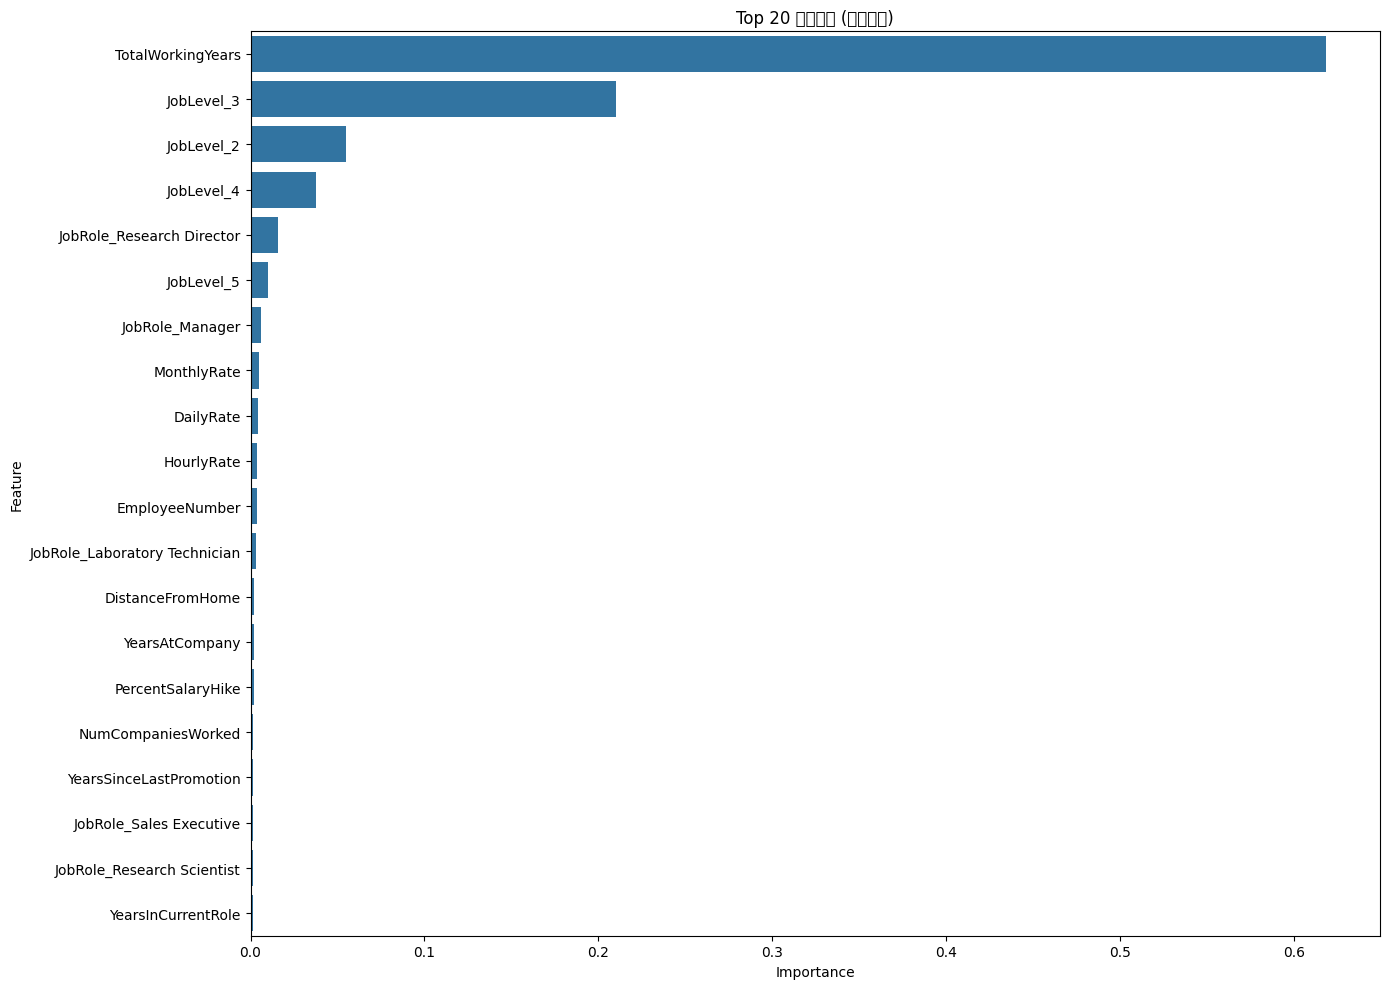

In [14]:
# 可视化特征
feature_importances = pd.DataFrame({ # 创建df
    'Feature': all_features,
    'Importance': rf_pipeline.named_steps['regressor'].feature_importances_
}).sort_values('Importance', ascending=False) #从随机森林模型获取的特征重要性分数

plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 重要特征 (随机森林)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

### 1.4三种线性回归算法

In [15]:
# 创建端到端的机器学习管道
def build_regression_model(model):
  return Pipeline(
      steps = [
            ('preprocessor',preprocessor),
            ('regressor',model)
      ]
  )

**正则化（Regularization）**

正则化是一种用于防止机器学习模型过拟合的技术，通过在损失函数中添加惩罚项来限制模型复杂度。

**核心思想：**

* 通过惩罚大系数值，防止模型过度依赖个别特征

* 在拟合数据和保持模型简单性之间取得平衡

* 数学表达：总损失 = 原始损失 + λ × 正则化项

**主要类型**

L1正则化 (Lasso)	： λΣ|wᵢ|

L2正则化 (Ridge)	：λΣwᵢ²

ElasticNet	： λ[(1-α)Σwᵢ² + αΣ|wᵢ|	]


**稀疏特征集（Sparse Feature Set）**

指在特征空间中，只有少数特征对预测结果有显著影响的数据特性。

**关键特点：**

* 大多数特征系数为零或接近零

* 少数特征具有显著非零系数

* 特征矩阵中大量零值元素

**在正则化中的体现：**

* L1正则化天然适合处理稀疏特征集会自动将不重要特征的系数压缩为零,实现自动特征选择

**现实示例：**

* 文本分类中：文档包含数千词语，但只有几十个关键词真正重要

* 基因表达数据：数万个基因中，只有少数与特定疾病相关

**正则化强度值（Regularization Strength）**

控制正则化惩罚项权重的超参数，通常表示为 λ 或 α。

**作用原理：**

模型复杂度 = 拟合程度 + α × 正则化惩罚
  
* α → 0：模型接近普通线性回归（可能过拟合）

* α → ∞：所有系数趋近零（欠拟合）

**5折交叉验证（5-fold Cross Validation）**

一种模型评估和超参数调优的技术，将数据集分成5份，轮流使用其中4份训练，1份验证。

**工作流程：**

* 将数据集随机分成5等份

* 进行5轮训练验证：



1.   第1轮：使用第1份验证，2-5份训练
2.   第2轮：使用第2份验证，1,3-5份训练

...

5. 第5轮：使用第5份验证，1-4份训练


在正则化回归模型中：


1. 使用5折交叉验证自动选择最佳正则化强度值

2. 正则化（特别是L1）帮助识别稀疏特征集

3. 三者共同作用：

* 防止过拟合（正则化）

* 自动调参（交叉验证）

* 特征选择（稀疏性）

例如在LassoCV中：


* 尝试50个不同的α值（正则化强度）

* 对每个α值进行5折交叉验证

* 选择在验证集上表现最好的α

* 最终模型自动产生稀疏特征集（部分系数归零）

这种组合使模型**更稳健、可解释**，且减少人工调参的需求。

In [16]:
# lasso回归（L1正则）
lasso_model = build_regression_model(
    LassoCV(alphas=np.logspace(-4,0,50),cv = 5,random_state=42,max_iter=5000)
)
lasso_model.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DailyRate',
                                                   'DistanceFromHome',
                                                   'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'HourlyRate', 'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'StandardHours',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'Year...
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00]),
                         cv=5, max_iter=5000, random_state=42))])

**Lasso 的核心特点：**

* 使用 L1 正则化（绝对值和）

* 倾向于将不重要的特征系数压缩为 0

* 自动执行特征选择

**LassoCV 参数详解：**

* alphas=np.logspace(-4, 0, 50)：创建 50 个正则化强度值（10⁻⁴ 到 10⁰）

* cv=5：5 折交叉验证选择最佳 alpha

* random_state=42：确保可重复性

* max_iter=5000：增加迭代次数确保收敛

**Lasso优势：**

* 自动识别并消除不重要的特征

* 创建更简单、可解释的模型

* 特别适合高维数据集（特征数量 > 样本数量）

In [17]:
# Ridge回归（L2回归）
ridge_model = build_regression_model(
    RidgeCV(alphas=np.logspace(-3,3,50),cv=5)
)
ridge_model.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DailyRate',
                                                   'DistanceFromHome',
                                                   'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'HourlyRate', 'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'StandardHours',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'Year...
       8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
                         cv=5))])

**Ridge 的核心特点：**

* 使用 L2 正则化（平方和）

* 缩小但不消除特征系数

* 特别适合处理共线性问题

**RidgeCV 参数详解：**

* alphas=np.logspace(-3, 3, 50)：更宽范围的正则化强度（10⁻³ 到 10³）

* cv=5：5 折交叉验证选择最佳 alpha

**Ridge优势：**

* 处理多重共线性（特征间高度相关）

* 稳定系数估计，减少方差

* 当所有特征都可能相关时效果更好

In [18]:
# ElasticNet（结合L1和L2正则化）
elastic_model = build_regression_model(
    ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                cv=5, max_iter=5000, n_jobs=-1)
)
elastic_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DailyRate',
                                                   'DistanceFromHome',
                                                   'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'HourlyRate', 'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'StandardHours',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'Year...
                                                   'Department', 'Education',
                                                   'EducationField',
                                                   'EnvironmentSatisfaction',
                                                   'Gender', 'JobInvolvement',
                                                   'JobLevel', 'JobRole',
                                                   'JobSatisfaction',
                                                   'MaritalStatus', 'Over18',
                                                   'OverTime',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'WorkLifeBalance'])])),
                ('regressor',
                 ElasticNetCV(cv=5,
                              l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                              max_iter=5000, n_jobs=-1))])

**ElasticNetCV（带交叉验证的ElasticNet）**


* 结合L1和L2正则化的优点

* 平衡特征选择和系数稳定性

**关键参数：**

* l1_ratio：控制L1/L2混合比例

* 0 = 纯Ridge

* 1 = 纯Lasso

* 中间值 = 混合

* n_jobs=-1：使用所有CPU核心加速计算

**适用场景：**
* 当数据集同时需要特征选择和共线性处理

### 1.5模型评价

**评估指标解释**

1. RMSE：
  √(Σ(yᵢ - ŷᵢ)²/n)

  预测值与实际值的平均偏差

  越小越好
2. R²

   1 - Σ(yᵢ - ŷᵢ)²/Σ(yᵢ - ȳ)²

   模型解释的方差比例

   0-1，越接近1越好

3. 交叉验证RMSE

  5次RMSE的平均±标准差

  模型稳定性评估

  标准差小表示稳定






Lasso 性能:
交叉验证 RMSE: 1065.7029 (±22.7366)
测试集 RMSE: 1149.1346
测试集 R²: 0.9396

Lasso选择的特征数量: 56/64
最重要的Lasso特征:
                          Feature   Coefficient
39                     JobLevel_5  11017.958391
38                     JobLevel_4   8356.932028
37                     JobLevel_3   4899.248416
42                JobRole_Manager   3627.383931
44      JobRole_Research Director   3328.408245
36                     JobLevel_2   1493.354140
41  JobRole_Laboratory Technician  -1218.545419
45     JobRole_Research Scientist  -1135.611852
47   JobRole_Sales Representative  -1024.724886
46        JobRole_Sales Executive    490.575269


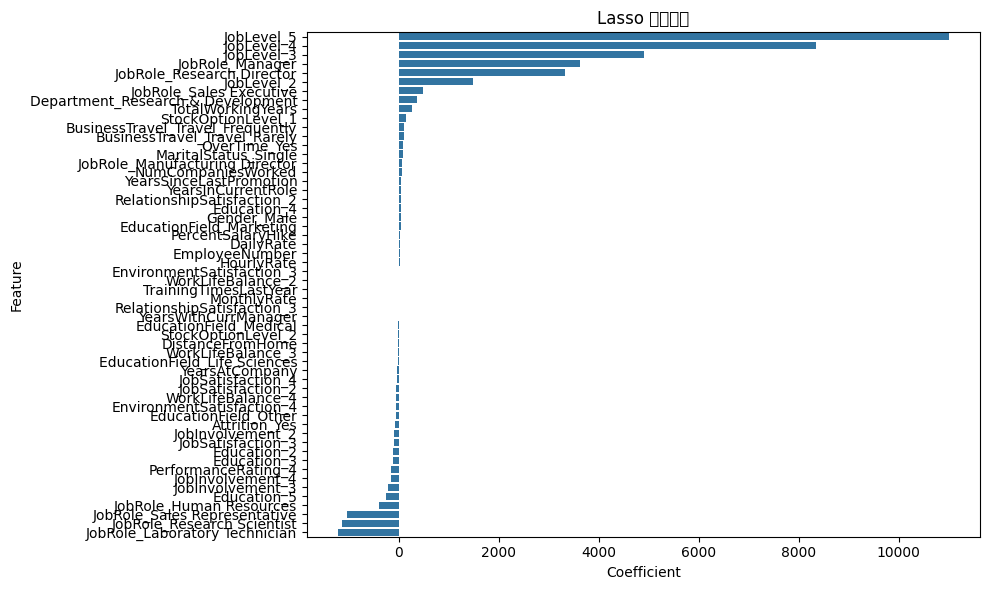


Ridge 性能:
交叉验证 RMSE: 1071.2399 (±25.6933)
测试集 RMSE: 1149.3215
测试集 R²: 0.9396

ElasticNet 性能:
交叉验证 RMSE: 1056.9957 (±21.9648)
测试集 RMSE: 1152.3815
测试集 R²: 0.9392

ElasticNet选择的特征数量: 37/64
最重要的ElasticNet特征:
                          Feature   Coefficient
39                     JobLevel_5  10544.677109
38                     JobLevel_4   7907.151722
37                     JobLevel_3   4651.739180
42                JobRole_Manager   3525.354220
44      JobRole_Research Director   3283.148447
36                     JobLevel_2   1328.012959
41  JobRole_Laboratory Technician  -1303.123604
45     JobRole_Research Scientist  -1230.339610
47   JobRole_Sales Representative  -1168.933145
40        JobRole_Human Resources   -524.579126


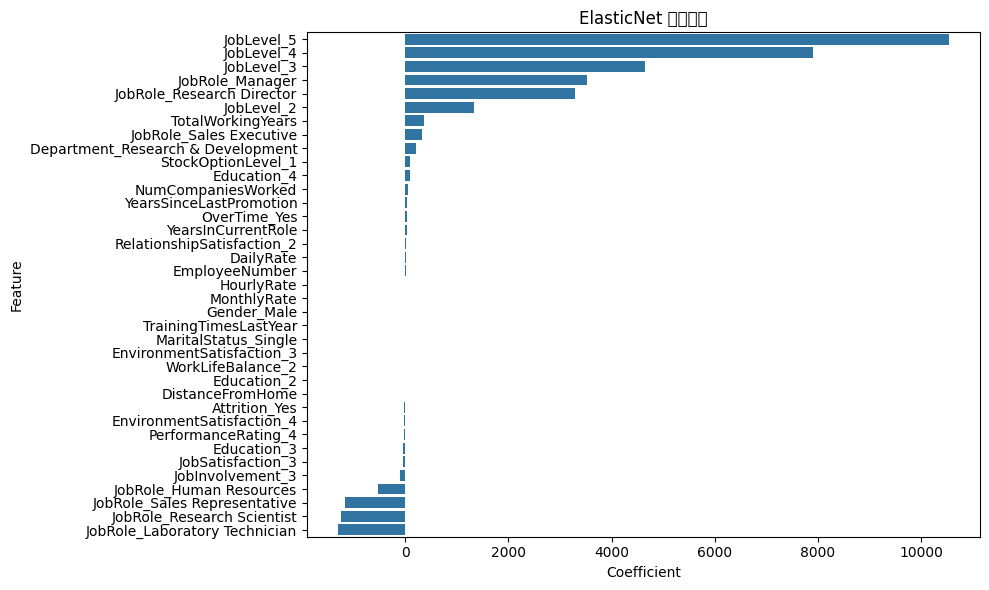

In [19]:
def evaluate_model(model, model_name):
    # 交叉验证
    cv_scores = cross_val_score(model, x_train, y_train,
                               cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)

    # 测试集评估
    y_pred = model.predict(x_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} 性能:")
    print(f"交叉验证 RMSE: {cv_rmse.mean():.4f} (±{cv_rmse.std():.4f})")
    print(f"测试集 RMSE: {test_rmse:.4f}")
    print(f"测试集 R²: {r2:.4f}")

    # 获取Lasso选择的特征
    if model_name in ["Lasso", "ElasticNet"]:
        try:
            coefs = model.named_steps['regressor'].coef_
            selected_features = [feat for feat, coef in zip(all_features, coefs) if abs(coef) > 0.001]
            print(f"\n{model_name}选择的特征数量: {len(selected_features)}/{len(all_features)}")

            # 显示最重要的特征
            coef_df = pd.DataFrame({
                'Feature': all_features,
                'Coefficient': coefs
            }).sort_values('Coefficient', key=abs, ascending=False)

            print(f"最重要的{model_name}特征:")
            print(coef_df.head(10))

            # 可视化系数
            plt.figure(figsize=(10, 6))
            significant_coefs = coef_df[coef_df['Coefficient'].abs() > 0.01]
            sns.barplot(x='Coefficient', y='Feature',
                        data=significant_coefs.sort_values('Coefficient', ascending=False))
            plt.title(f'{model_name} 特征系数')
            plt.tight_layout()
            plt.savefig(f'{model_name.lower()}_coefficients.png', dpi=300)
            plt.show()

            return selected_features
        except:
            pass
    return []

# 评估模型
lasso_features = evaluate_model(lasso_model, "Lasso")
ridge_features = evaluate_model(ridge_model, "Ridge")
elastic_features = evaluate_model(elastic_model, "ElasticNet")

1. **Lasso评估：**

  计算交叉验证和测试集性能

  分析选择的特征及系数

  返回非零特征列表

  保存系数可视化图 lasso_coefficients.png

2. **Ridge评估：**

  计算性能指标

  不进行特征选择分析（Ridge不产生稀疏解）

  返回空列表

3. **ElasticNet评估：**

  类似Lasso的分析

  保存 elasticnet_coefficients.png

1. **为什么使用负MSE？**

  Scikit-learn约定：更高的分数=更好的性能

  负MSE确保最大化分数等同于最小化MSE

2. **特征选择阈值 (0.001)**

  实际应用中系数的"零"是相对的

  设置小阈值避免忽略微弱信号

  可根据业务需求调整

3. **可视化阈值 (0.01)**

  聚焦显著影响特征
  
  避免图表过于拥挤
  
  突出关键业务洞察

In [21]:
# 最终特征选择
# 组合所有模型选择的特征
all_selected_features = set(lasso_features + elastic_features + list(feature_importances.head(30)['Feature']))

print("\n" + "="*50)
print("分析与建议:")
print(f"1. 随机森林识别出 {len(feature_importances[feature_importances['Importance'] > 0.005])} 个重要特征")
print(f"2. Lasso选择 {len(lasso_features)} 个特征，ElasticNet选择 {len(elastic_features)} 个特征")
print(f"3. 合并后推荐 {len(all_selected_features)} 个特征用于最终建模") #取并集

print("\n推荐的特征选择策略:")
print("A. 对于需要解释性的模型:")
print("   - 使用Lasso或ElasticNet的特征选择结果")
print("B. 对于预测性能优先的模型:")
print("   - 使用随机森林重要性前30的特征")

# 12. 保存重要特征列表
important_features_df = pd.DataFrame({
    'Feature': list(all_selected_features),
    'RF_Importance': [feature_importances.set_index('Feature').loc[f, 'Importance']
                      if f in feature_importances['Feature'].values else 0
                      for f in all_selected_features]
})



分析与建议:
1. 随机森林识别出 7 个重要特征
2. Lasso选择 56 个特征，ElasticNet选择 37 个特征
3. 合并后推荐 58 个特征用于最终建模

推荐的特征选择策略:
A. 对于需要解释性的模型:
   - 使用Lasso或ElasticNet的特征选择结果
B. 对于预测性能优先的模型:
   - 使用随机森林重要性前30的特征


In [22]:
# 添加Lasso系数
if lasso_features:
    coef_df = pd.DataFrame({
        'Feature': all_features,
        'Lasso_Coefficient': lasso_model.named_steps['regressor'].coef_
    })
    important_features_df = important_features_df.merge(coef_df, on='Feature', how='left')

# 保存到CSV
important_features_df.sort_values('RF_Importance', ascending=False, inplace=True)
important_features_df.to_csv('selected_features.csv', index=False)
print("\n已保存选定的特征到 'selected_features.csv'")



已保存选定的特征到 'selected_features.csv'


## 2.逻辑回归

**线性组合**

$$z = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_nx_n = \mathbf{x}^T\boldsymbol{\beta}$$

**Sigmoid函数**

$$P(y=1|\mathbf{x}) = \sigma(z) = \frac{1}{1 + e^{-z}}$$


**损失函数（交叉熵）：**

$$J(\boldsymbol{\beta}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1-y_i)\log(1-p_i) \right]$$

**带L2正则化的损失函数：**

$$J_{\text{reg}}(\boldsymbol{\beta}) = J(\boldsymbol{\beta}) + \lambda \sum_{j=1}^{p} \beta_j^2$$

**梯度更新：**

$$\beta_j^{(k+1)} = \beta_j^{(k)} - \alpha \frac{\partial J}{\partial \beta_j}$$



$$\frac{\partial J}{\partial \beta_j} = \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)x_{ij}$$

### 2.1数据预处理

当数据集中不同类别的样本数量差异悬殊时，称为样本不平衡。例如：

离职员工(Attrition=1)：200人

在职员工(Attrition=0)：1800人

比例：1:9

这会导致模型偏向多数类，因为损失函数会被多数类主导。


- 模型可能简单地将所有样本预测为多数类，导致准确率很高但无法识别正类。
- 评估指标如准确率会失效，需要采用精确率、召回率、F1分数或AUC-ROC等。

**数学影响：**
- 损失函数偏差：

少数类贡献被淹没

- 决策边界偏移：

→总是预测多数类

- 评估指标失真：



准确率可能高达90%，但召回率为0


AUC-ROC曲线下面积可能虚高

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [24]:
# 检测离职比例
print("离职比例:\n", ibmdata['Attrition'].value_counts(normalize=True))


离职比例:
 Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [25]:
# 初始数据清理
ibmdata_clean = ibmdata.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1)
ibmdata_clean['Attrition'] = ibmdata_clean['Attrition'].map({'Yes':1, 'No':0})

# 1. 清理列名（去除空格和特殊字符）
ibmdata_clean.columns = ibmdata_clean.columns.str.strip()
print("清理后的列名:", ibmdata_clean.columns.tolist())

# 2. 调整分类列列表（使用实际列名）
cat_cols = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender',
    'JobRole', 'MaritalStatus', 'OverTime',
    'Education', 'EnvironmentSatisfaction',
    'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel',
    'WorkLifeBalance'
]


# 执行独热编码
ibmdata_clean = pd.get_dummies(ibmdata_clean, columns=cat_cols, drop_first=True)
print('当前列名：',ibmdata_clean.columns.tolist())

清理后的列名: ['Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
当前列名： ['Attrition', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'Educa

### 2.2样本不平衡

**样本不平衡时的处理方法：**

- SMOTE新样本生成：



1. 对于每个少数类样本 $\mathbf{x}_i$

  找到k个最近邻少数类样本 $\mathbf{x}_{nn}$

2. 随机生成新样本：
$$\mathbf{x}_{\text{new}} = \mathbf{x}_i + \lambda (\mathbf{x}_{nn} - \mathbf{x}_i)$$
$$\lambda \sim \text{Uniform}(0,1)$$

3. 重复直到类别平衡

  **优点：**保持特征分布特性

  **缺点：**可能引入噪声

- 类别权重调整
1. 修改损失函数，增加少数类权重：

- 类别权重调整：



$$w_i = \begin{cases}
\frac{N}{2 \times N_1} & y_i = 1 \\
\frac{N}{2 \times N_0} & y_i = 0
\end{cases}$$

- 加权损失函数：



$$J_w(\boldsymbol{\beta}) = -\frac{1}{N} \sum_{i=1}^{N} w_i \left[ y_i \log(p_i) + (1-y_i)\log(1-p_i) \right]$$

  **优点：**不改变数据分布
  
  **缺点：**不能创造新信息




In [26]:
X_log = ibmdata_clean.drop('Attrition',axis = 1)
y_log = ibmdata_clean['Attrition']
# 处理不平衡
# 1：smote过采样
smote = SMOTE(random_state=42)
X_log_res,y_log_res = smote.fit_resample(X_log,y_log)
# 2.使用class_weight参数 (在模型训练步骤设置)

### 2.3 特征选择

In [27]:
# 特征选择 - 选择与目标相关性高的特征
corr_matrix = ibmdata_clean.drop('Attrition', axis=1).corrwith(ibmdata_clean['Attrition']).abs()
selected_features_log = corr_matrix[corr_matrix > 0.05].index.tolist()
X_log = X_log_res[selected_features_log]

# 标准化
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

In [28]:
# 划分数据集
X_log_train,X_log_test,y_log_train,y_log_test = train_test_split(
    X_log_scaled,y_log_res,test_size = 0.3,random_state = 42)


In [29]:
# 模型训练
# 使用smote方法
# model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
# 使用class_weight平衡：
model = LogisticRegression(penalty='l2',class_weight = 'balanced',solver='liblinear',random_state=42)
model.fit(X_log_train,y_log_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

### 2.4模型评估

1. **混淆矩阵**：
   - 直观展示分类结果，分为四类：
        - 真阳性（TP）：正确预测的离职人数。
        - 假阳性（FP）：错误预测的离职人数（实际未离职）。
        - 真阴性（TN）：正确预测的未离职人数。
        - 假阴性（FN）：错误预测的未离职人数（实际离职）。
2. **召回率（Recall）**：
   - 又称灵敏度或真正例率（TPR）。
   - 计算公式：Recall = TP / (TP + FN)
   - 意义：在所有实际离职的员工中，模型能够正确识别出的比例。该指标越高，说明漏报的离职员工越少。
3. **ROC曲线（Receiver Operating Characteristic Curve）**：
   - 描述TPR（召回率）与FPR（假阳性率）之间关系的曲线。
   - 横轴FPR = FP / (FP + TN)，即实际未离职员工中被错误预测为离职的比例。
   - 纵轴TPR = Recall。
4. **AUC（Area Under the ROC Curve）**：
   - ROC曲线下的面积，取值范围在0.5到1之间。
   - 意义：AUC值越大，说明模型区分正负样本的能力越强。AUC=0.5时，模型没有区分能力；AUC=1时，模型完美区分。


**在离职预测场景中的关注点：**


- 由于离职通常属于少数类，我们更关注召回率（尽量减少漏报）。
- 但也要注意假阳性率（FPR）不能太高，否则会误伤很多实际不会离职的员工（比如采取挽留措施会造成不必要的成本）。
- 因此，需要结合业务需求在召回率和精确率（Precision）之间权衡（可使用PR曲线）。

In [30]:
# 预测概率
y_log_prob = model.predict_log_proba(X_log_test)[:,1]
print("\n概率输出示例:", y_log_prob[:5])


概率输出示例: [-7.15998260e+00 -9.88213413e-01 -3.84287670e+00 -1.53025345e-02
 -5.87350070e-03]


predict_log_proba() 返回每个样本属于两类（0=未离职，1=离职）的概率

[:, 1] 只取属于"离职"类别的概率值

输出示例：如 [0.85, 0.12, 0.93, 0.04, 0.78] 表示第一个样本有85%的概率离职

<function matplotlib.pyplot.show(close=None, block=None)>

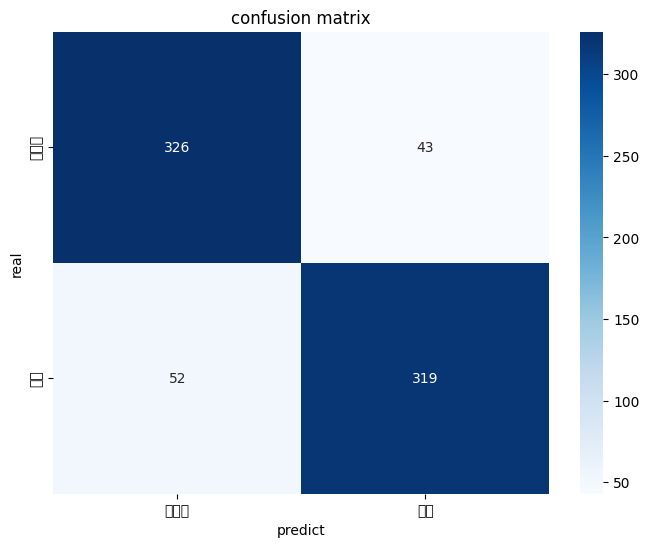

In [31]:
# 混淆矩阵
y_log_pred = model.predict(X_log_test)
cm = confusion_matrix(y_log_test,y_log_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot = True,fmt = 'd',cmap = 'Blues',
            xticklabels = ['未离职', '离职'],
            yticklabels=['未离职', '离职'])
plt.xlabel('predict')
plt.ylabel('real')
plt.title('confusion matrix')
plt.show

   - 混淆矩阵的四个格子分别是：
        - 左上（TN）：真实未离职，预测未离职
        - 右上（FP）：真实未离职，预测离职（误报）
        - 左下（FN）：真实离职，预测未离职（漏报）**最需关注的错误**
        - 右下（TP）：真实离职，预测离职



- 深蓝色对角线（TN和TP）越大越好

- 关注右上角（FN）是否最小化

In [32]:
# 召回率计算
tn,fp,fn,tp = cm.ravel()
recall = tp/(tp+fn)
print(f"召回率(离职检测率): {recall:.4f}")

召回率(离职检测率): 0.8598


召回率 (Recall)：$ \frac{TP}{TP+FN} $

业务意义：在所有实际离职的员工中，模型能正确识别出的比例

**重要性：**在离职预测中，召回率比准确率更重要（避免人才流失比避免误报更重要）

示例：召回率0.75 = 每100个离职员工中能识别出75人

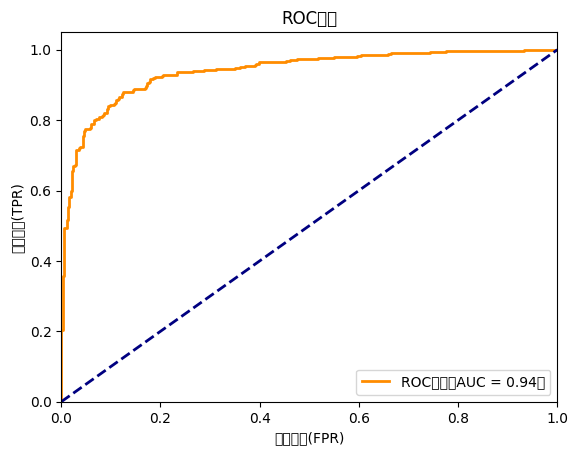


分类评估报告:
              precision    recall  f1-score   support

         未离职       0.86      0.88      0.87       369
          离职       0.88      0.86      0.87       371

    accuracy                           0.87       740
   macro avg       0.87      0.87      0.87       740
weighted avg       0.87      0.87      0.87       740



In [33]:
# ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_log_test, y_log_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr,color='darkorange',lw = 2,label=f'ROC曲线（AUC = {roc_auc:.2f}）')
plt.plot([0,1],[0,1],color = 'navy',lw = 2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('假阳性率(FPR)')
plt.ylabel('真阳性率(TPR)')
plt.title('ROC曲线')
plt.legend(loc="lower right")
plt.show()

# 分类报告
print("\n分类评估报告:")
print(classification_report(y_log_test, y_log_pred, target_names=['未离职', '离职']))

- 关键指标：

  - FPR (False Positive Rate)：$ \frac{FP}{FP+TN} $

    - 实际未离职员工中被错误标记的比例

    - 横坐标轴，范围0-1

  - TPR (True Positive Rate)：即召回率，纵坐标轴

  - AUC (Area Under Curve)：ROC曲线下面积

- ROC曲线解读：

    - 曲线越靠近左上角，模型性能越好

    - 对角线（AUC=0.5）表示随机猜测

  - 曲线上的每个点对应不同的分类阈值

  

**AUC范围	模型判别能力**

0.9-1.0	极佳

0.8-0.9	很好

0.7-0.8	一般

0.6-0.7	较差

0.5-0.6	基本无判别能力

**离职预测场景的关键指标优先级**

1. 召回率 (Recall)：首要指标，确保尽可能多的离职员工被识别

2. AUC值：全面评估模型在不同阈值下的表现

3. 精确率 (Precision)：$ \frac{TP}{TP+FP} $（未在代码中计算）

  - 衡量预测为离职的员工中实际离职的比例

  - 与召回率存在trade-off关系



**ROC曲线：**

  - 曲线应明显高于对角线

  - AUC > 0.8 表示模型具有良好的判别能力

  - 曲线陡峭上升表明模型能在低FPR下获得高TPR


## 3.KMeans聚类
***核心思想***

K-means聚类是一种无监督学习算法，用于将数据点划分为K个不同的组（称为簇），使得同一簇内的数据点彼此相似，而不同簇的数据点彼此不同。相似性通常通过数据点之间的距离来衡量（如欧几里得距离）。K-means的目标是最小化簇内平方和（即每个点到其簇中心的距离平方和）。

想象你有一堆散落的糖果，你想把它们按颜色分成K组（比如K=3：红色、绿色、蓝色）。但糖果颜色可能不是纯色，而是渐变的。K-means的做法是：
1. 随机选K个糖果作为初始中心（代表色）。
2. 给每个糖果分配一个组：计算每个糖果到各个中心的距离，将其分配到最近中心的那组。
3. 重新计算中心：对每组糖果，计算其平均颜色，作为新的中心。
4. 重复步骤2和3，直到中心不再变化（或变化很小）。






### 3.1数学知识补充

 **1. 凸优化（Convex Optimization）:**
- **通俗解释**：想象你在一个光滑的碗里放一个小球。无论你从哪里放，小球最终都会滚到碗底（最低点）。这种问题就是凸优化问题——只有一个最低点（全局最优解），你能找到它。
- **在K-Means中的体现**：当数据点的分配固定时（即知道每个点属于哪个簇），重新计算簇中心（求均值）这一步是一个凸优化问题。因为目标函数（簇内平方和）在固定分配时是凸函数，所以求导更新中心点（即求簇内点的均值）一定能得到该分配下的最优中心点。
- **为什么重要**：这保证了K-Means的每次迭代（更新中心点）都会让目标函数（WCSS）下降或不变，不会变差。

**2. 局部最优（Local Optima）**

- **通俗解释**：现在想象你在一片多山的区域。你站在某个山坡上，往下走到你所在小山谷的最低点（局部最低点），但这不是整个区域的最低点（全局最低点）。因为你没有翻山越岭，所以被困在了这个小山谷里。
- **在K-Means中的体现**：K-Means的最终结果依赖于初始中心点的选择。如果初始中心点选得不好，算法可能收敛到一个局部最优解（即这个解在它的“小区域”里是最优的，但不是整个问题的最优解）。比如，你可能把数据分成了3个簇，但换一组初始中心点，可能会得到更好的划分（WCSS更小）。
- **如何应对**：通常我们会多次运行K-Means（比如10次），每次用不同的初始中心点，然后选择其中WCSS最小（即目标函数值最小）的那次结果。

**3. 线性复杂度（Linear Complexity）**

- **通俗解释**：假设你有n个数据点，要分成K个簇，每个点是d维。线性复杂度（这里指每次迭代的时间复杂度是O(n*K*d)）意味着：
  - 如果数据量n翻倍，计算时间也大约翻倍。
  - 如果簇数K翻倍，计算时间也大约翻倍。
  - 如果特征维度d翻倍，计算时间也大约翻倍。
- **为什么重要**：这使得K-Means能够处理非常大的数据集。因为计算时间随着数据规模线性增长，而不是指数增长（那会非常慢）。

**4. 球形簇假设（Spherical Cluster Assumption）**

- **通俗解释**：K-Means使用欧氏距离（即直线距离），所以它倾向于把数据分成像“球”一样的簇（即簇在各个方向上都是均匀的）。这意味着：
  - 如果真实的簇是拉长的（比如椭圆形），或者是不规则形状（比如月牙形），K-Means可能分得不好。
  - 如下图，左边是K-Means期望的簇（球形），右边是它可能处理不好的情况（非球形）：
    ```
    球形簇： ●●●      非球形簇： ●●●●●
         ●●●                 ●●●●●
         ●●●
    ```
- **数学原因**：因为K-Means的目标函数是最小化簇内平方和（WCSS），这等价于假设每个簇的数据点围绕中心呈球形对称分布（即高斯分布）。
- **如何改进**：如果数据不是球形的，可以使用其他聚类方法，比如DBSCAN（基于密度的聚类）或谱聚类（Spectral Clustering）。
               |

---

***问题定义***

- 数据集：$X = \{x_1, x_2, \dots, x_n\}$，其中每个$x_i \in \mathbb{R}^d$（d维特征向量）
- 特征维度：每个 $x_i \in \mathbb{R}^d$（d维特征向量）
- 簇的数量：K（用户指定）

找到K个簇中心（质心）$C = \{c_1, c_2, \dots, c_K\}$（每个$c_k \in \mathbb{R}^d$）和每个数据点的簇分配（用指示变量$r_{ik}$表示），使得簇内平方和（WCSS）最小：

$$\min \sum_{i=1}^{K} \sum_{x \in C_i} \|x - \mu_i\|^2$$


其中：

  * $C_i$ 是第 i 个簇（组）
  
  * $\mu_i$ 是第 i 个簇的中心点
  
  * $|x - \mu_i|$ 是欧氏距离（两点间的直线距离）


**步骤详解：**


1. **初始化**：随机选择K个数据点作为初始簇中心 $\mu_1^{(0)}, ..., \mu_K^{(0)}$（或使用其他初始化方法如K-means++）。
2. **分配步骤**：

$$C_i^{(t)} = \left\{ x : \|x - \mu_i^{(t)}\|^2 \leq \|x - \mu_j^{(t)}\|^2 \ \forall j, 1 \leq j \leq K \right\}$$


   即：将每个点分配给距离最近的簇中心。
3. **更新步骤**：

$$\mu_i^{(t+1)} = \frac{1}{|C_i^{(t)}|} \sum_{x_j \in C_i^{(t)}} x_j$$

   对每个簇$k$，重新计算中心为该簇所有点的均值：

4. **重复**：交替执行步骤2和步骤3，直到中心不再变化（或变化小于阈值）或达到最大迭代次数。

$$\|\mu_i^{(t+1)} - \mu_i^{(t)}\| < \epsilon \quad \text{（通常} \epsilon = 10^{-6}\text{）}$$


---

**关键数学概念**


- **距离度量**：通常使用欧几里得距离（平方以简化计算）。



- **簇中心（质心）**：本质：簇内所有点的平均值



- **目标函数（WCSS）的几何意义：**

  - 衡量簇内紧密程度

  - 值越小表示聚类效果越好

  - 算法本质是坐标下降优化过程
- **初始化敏感**：随机初始化可能导致不同结果，常用K-means++（智能初始化）缓解。

- **收敛性**：算法保证在有限步内收敛到局部最优（但不一定是全局最优）。

- **复杂度**：每次迭代O(n*K*d)，高效且可扩展。

**优缺点**


1. **优点**：
  - 简单、高效（尤其适用于大规模数据）。
  - 易于实现和理解。

2. **缺点**：

  - 需预先指定K（可通过肘部法、轮廓系数等选 择）。
  - 对异常值敏感（可使用K-medoids改进）。
  - 假设簇是凸形和等方差（对非球形簇效果差）。
  - 对初始中心敏感（多次运行取最优）。


**使用Kmeans聚类可能遇到的问题**

**问题1：初始点敏感**

- 比喻：在不同位置扔石子产生不同涟漪

- 数学表现：

 - 随机初始化：可能选中边缘点导致分组失衡

  - K-Means++：优先选择相距远的点作为初始中心

  - 概率公式：$P(\text{选}x) \propto D(x)^2$ (D=到最近中心的距离)

  - K-Means++ 初始化概率
$$P(x) = \frac{D(x)^2}{\sum_{x \in X} D(x)^2}$$
其中 $D(x)$ 是点到最近中心的距离

**问题2：K值未知**

- 肘部法则图解：




```
WCSS值
  |✘
  | ✘
  |  ✘ ← 肘点（最佳K=3）
  |   ✘
  |______
       K值

```

- 数学原理：当K超过真实簇数时，WCSS下降变缓
- 肘部法则目标函数
$$J(K) = \sum_{i=1}^{K} \sum_{x \in C_i} \|x - \mu_i\|^2$$


**问题3：异常值敏感**


- 例子：99个点在[0,1]区间，1个点在100

- 数学原因：

  - 均值计算：$\mu = \frac{1}{n}\sum x_i$ ← 被异常值拉偏

  - 平方距离：$|x-\mu|^2$ 放大异常值影响

- 解决方案：

  - K-Medoids：用实际数据点（中值）代替均值

  - 数学公式：$\min \sum |x - m|$ （m是簇中实际存在的点）


### 3.2数据处理

In [34]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# 加载数据
fp = '/content/IBM_HR_Analytics.csv'
km = pd.read_csv(fp,index_col = 0)

km_original = km.copy()

# 数据清洗
km.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)  # 删除常量列
km['Attrition'] = km['Attrition'].map({'Yes':1, 'No':0})  # 标签编码

# 独热编码分类变量
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender',
            'JobRole', 'MaritalStatus', 'OverTime']
km = pd.get_dummies(km, columns=cat_cols)

# 标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(km.drop('Attrition', axis=1))

### 3.3特征降维，肘部法则

#### 3.3.1 PCA降维
**1. PCA 是什么？**

  PCA（主成分分析）是一种无监督降维技术，核心思想是通过线性变换将原始特征转换为一组新的正交特征（主成分），这些主成分按解释数据变异能力从大到小排序。

**2. 为什么要保留数据方差？**

  方差 = 数据变异程度 = 信息量

  PCA 的核心原理：**最大方差理论**

  → 主成分的方向就是数据方差最大的方向

  → 保留最大方差 = 保留最多信息

  参数设置：n_components=0.95

  - 含义：自动选择最少的主成分数量，使这些主成分  累计解释95% 的总方差

  - 为什么是95%？这是经验值：

    - 100%：保留所有信息（但失去降维意义）

    - 95-99%：平衡信息保留和降维效果

    - <90%：可能丢失重要信息

**3. PCA 特征重要性计算原理**

  核心矩阵：pca.components_
  形状：(n_components, n_features)

  **物理意义：**

  

```
  [
    [w11, w12, ..., w1p],  # 第一主成分中每个特 征的权重
    [w21, w22, ..., w2p],  # 第二主成分中每个特 征的权重
    ...
  ]
```
  **重要性计算**：np.abs(pca.components_).sum (axis=0)

    1. 取绝对值：np.abs()
      → 忽略权重方向（正/负相关），只关注影响强度

    2. 按列求和：.sum(axis=0)
      → 将特征在所有主成分上的影响强度相加

  **为什么这样计算？**

    - 理论基础： 特征在重要主成分中权重越大，对数据  结构的贡献越大

    - 数学解释：重要性得分 = Σ|w_ij| （i从1到k个主成分）。相当于特征在"新坐标系"中的总影响力

**4. 注意事项：**
  - 线性假设：PCA 只能捕捉线性关系
  
  - 尺度敏感：必须先标准化（代码中已用  StandardScaler）
  - 分类特征：独热编码可能稀释重要性（需谨慎解释）
  - 结果解读：重要性高 ≠ 预测能力强（是无监督视角）



> PCA 特征重要性衡量的是特征对数据整体结构的贡献度，而非预测能力。它回答的问题是："哪些特征在解释数据变异时最重要？"





In [35]:
# --- 引入PCA进行降维 ---
# PCA可以帮助我们减少特征数量，同时保留大部分方差，去除一些噪音和共线性
# 我们通常选择解释90%或95%方差的主成分数量
pca = PCA(n_components=0.99, random_state=42) # 保留95%的方差
X_pca = pca.fit_transform(scaled_data)

print(f"\n原始特征数量: {scaled_data.shape[1]}")
print(f"PCA降维后特征数量: {X_pca.shape[1]}")
print(f"解释方差比例: {pca.explained_variance_ratio_.sum():.4f}")

# 现在我们将使用 X_pca 进行聚类
X_for_clustering = X_pca


原始特征数量: 51
PCA降维后特征数量: 39
解释方差比例: 0.9914


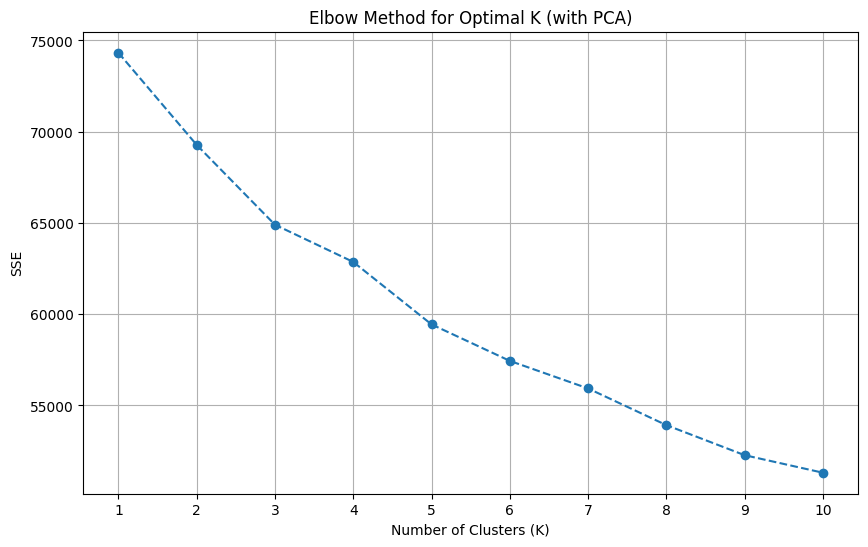


根据肘部法则曲线，预期拐点K=3（通常不会有太大变化，但可能更清晰）。


In [36]:
# 肘部法则
sse = []
k_values = range(1, 11) # 尝试K从1到10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (with PCA)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.xticks(k_values)
plt.grid(True)
plt.show()

print("\n根据肘部法则曲线，预期拐点K=3（通常不会有太大变化，但可能更清晰）。")

#### 3.3.2 聚类质量评估
**聚类质量评估指标：**
1. 轮廓系数(Silhouette Score)：

  - 衡量一个点与其自己簇的相似度 vs 与其他簇的相似度

  - 范围：-1（最差）到 1（最好）

  - 值越大表示聚类效果越好

2. Calinski-Harabasz指数(CH指数)：

  - 衡量簇间距离（分离度）vs 簇内距离（紧密度）

  - 没有固定范围，但越大越好

  - 值越大表示簇间分离明显、簇内紧密

3. 综合评分：

  - 0.7*ch_score + 0.3*sil_score 是加权平均

  - 给CH指数70%权重（侧重簇间分离）

  - 给轮廓系数30%权重（侧重簇内紧密）

  - 这个比例可以根据需要调整

In [37]:


# --- 更激进的PCA降维 ---
# 尝试更少的主成分数量
n_components_to_try = [5, 8, 10, 12, 15] # 可以根据实际情况调整这些值

best_silhouette_score = -1
best_k = -1
best_n_components = -1
best_labels = None

print("--- 尝试不同主成分数量下的聚类效果 ---")
for n_comp in n_components_to_try:
    pca_aggressive = PCA(n_components=n_comp, random_state=42)
    X_pca_aggressive = pca_aggressive.fit_transform(scaled_data)

    print(f"\n使用 {n_comp} 个主成分 (解释方差: {pca_aggressive.explained_variance_ratio_.sum():.4f}):")
    # 在新的降维数据上计算不同K值下的轮廓系数
    current_best_k_score = -1
    current_best_k_val = -1
    current_best_labels = None

    for k in range(2, 11): # 依然尝试K从2到10
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels_k = kmeans.fit_predict(X_pca_aggressive)
        score = silhouette_score(X_pca_aggressive, cluster_labels_k)
        print(f"  K = {k}, 轮廓系数 = {score:.4f}")

        if score > current_best_k_score:
            current_best_k_score = score
            current_best_k_val = k
            current_best_labels = cluster_labels_k

    if current_best_k_score > best_silhouette_score:
        best_silhouette_score = current_best_k_score
        best_k = current_best_k_val
        best_n_components = n_comp
        best_labels = current_best_labels

print(f"\n--- 最佳聚类结果 ---")
print(f"最佳主成分数量: {best_n_components}")
print(f"最佳 K 值: {best_k}")
print(f"最高轮廓系数: {best_silhouette_score:.4f}")

# 使用最佳参数进行最终聚类
pca_final = PCA(n_components=best_n_components, random_state=42)
X_pca_final = pca_final.fit_transform(scaled_data)
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_cluster_labels = kmeans_final.fit_predict(X_pca_final)

# 将最终聚类结果添加到原始数据框中
km_original['Cluster'] = final_cluster_labels

--- 尝试不同主成分数量下的聚类效果 ---

使用 5 个主成分 (解释方差: 0.3024):
  K = 2, 轮廓系数 = 0.2418
  K = 3, 轮廓系数 = 0.3151
  K = 4, 轮廓系数 = 0.3539
  K = 5, 轮廓系数 = 0.3037
  K = 6, 轮廓系数 = 0.2931
  K = 7, 轮廓系数 = 0.2935
  K = 8, 轮廓系数 = 0.2899
  K = 9, 轮廓系数 = 0.2863
  K = 10, 轮廓系数 = 0.2946

使用 8 个主成分 (解释方差: 0.4143):
  K = 2, 轮廓系数 = 0.1758
  K = 3, 轮廓系数 = 0.2140
  K = 4, 轮廓系数 = 0.2418
  K = 5, 轮廓系数 = 0.2020
  K = 6, 轮廓系数 = 0.1773
  K = 7, 轮廓系数 = 0.1898
  K = 8, 轮廓系数 = 0.1839
  K = 9, 轮廓系数 = 0.1725
  K = 10, 轮廓系数 = 0.1817

使用 10 个主成分 (解释方差: 0.4803):
  K = 2, 轮廓系数 = 0.1554
  K = 3, 轮廓系数 = 0.1817
  K = 4, 轮廓系数 = 0.2059
  K = 5, 轮廓系数 = 0.1579
  K = 6, 轮廓系数 = 0.1509
  K = 7, 轮廓系数 = 0.1440
  K = 8, 轮廓系数 = 0.1505
  K = 9, 轮廓系数 = 0.1355
  K = 10, 轮廓系数 = 0.1445

使用 12 个主成分 (解释方差: 0.5355):
  K = 2, 轮廓系数 = 0.1368
  K = 3, 轮廓系数 = 0.1592
  K = 4, 轮廓系数 = 0.1488
  K = 5, 轮廓系数 = 0.1374
  K = 6, 轮廓系数 = 0.1397
  K = 7, 轮廓系数 = 0.1230
  K = 8, 轮廓系数 = 0.1231
  K = 9, 轮廓系数 = 0.1222
  K = 10, 轮廓系数 = 0.1286

使用 15 个主成分 (解释方差: 0.6076):
  K = 

PCA降维导致信息丢失，通常认为轮廓系数>0.5是较好的聚类效果，虽然改进后的pca有显著提升，但仍未达到需求。K-Means和线性PCA在处理复杂。 非球形或高维数据时有一定的局限性。


- 更高级的降维技术： 线性PCA可能无法捕获数据中非线性的复杂结构。

- 更灵活的聚类算法： 能够处理非球形簇、不同密度或重叠簇的算法。

#### 3.3.3 非线性降维法
当线性PCA无法有效揭示数据的内在结构时，**非线性降维**方法可以大显身手。它们的目标是将高维数据映射到低维空间（通常是2D或3D），同时尽可能保留数据点之间的局部和全局关系。这能帮助我们“看清”数据中更复杂的簇结构。

- UMAP (Uniform Manifold Approximation and Projection)：

  - 优点： 通常比t-SNE更快，更适合大数据集，并且能更好地保留  全局结构，这意味着簇之间的相对位置在降维后仍有意义。它在  保持局部邻域的同时，也试图保持更远的距离关系。

  - 用法： 在降维后的2D/3D空间中，您通常能看到清晰的数据点聚  集，然后可以在这个低维空间上应用K-Means或其他聚类算法。

- t-SNE (t-Distributed Stochastic Neighbor Embedding)：

  - 优点： 非常擅长揭示高维数据中的局部结构，将相似的数据点聚 集在一起，不相似的数据点分开。在可视化数据中的簇时特别有 效。

  - 缺点： 计算成本较高，不适合非常大的数据集。主要关注局部结 构，因此不同簇之间的距离可能没有实际意义。

推荐：先尝试UMAP，因为它在速度和全局结构保留方面通常更均衡。


UMAP降维后特征数量: 3


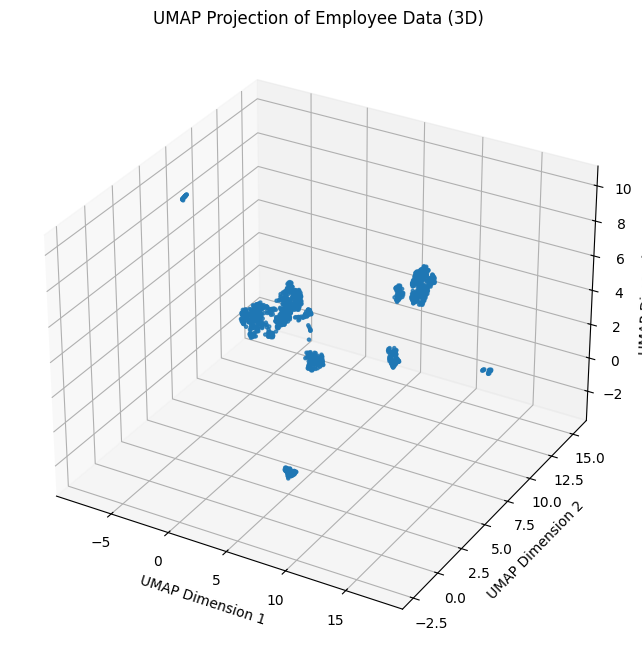


UMAP降维后不同K值下的轮廓系数：
  K = 2, 轮廓系数 = 0.5879
  K = 3, 轮廓系数 = 0.6581
  K = 4, 轮廓系数 = 0.7072
  K = 5, 轮廓系数 = 0.7353
  K = 6, 轮廓系数 = 0.7378
  K = 7, 轮廓系数 = 0.6392
  K = 8, 轮廓系数 = 0.6615
  K = 9, 轮廓系数 = 0.6973
  K = 10, 轮廓系数 = 0.7120


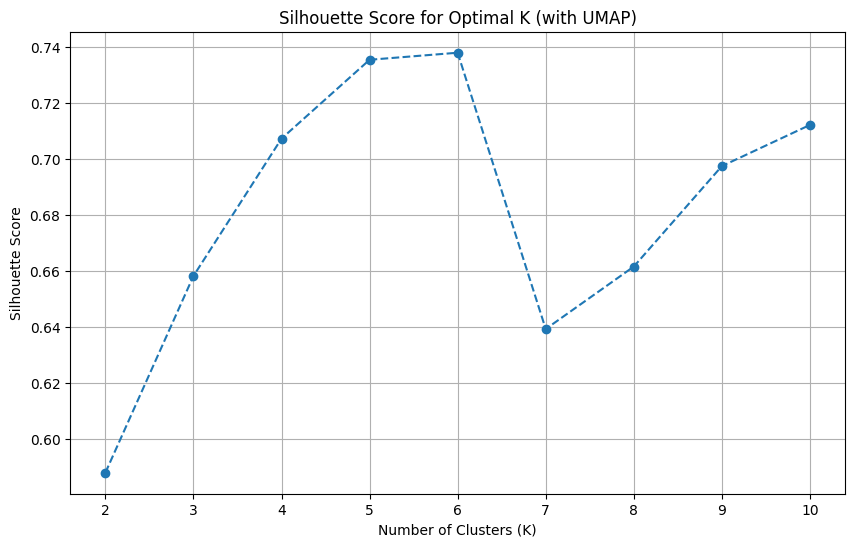

In [38]:
import umap.umap_ as umap

# scaled_data是标准化后的数据（未进行任何PCA降维）
# 我们直接在标准化后的数据上进行UMAP降维

# UMAP参数调整建议：
# n_neighbors: 局部邻居的数量，值越大，UMAP越关注全局结构；值越小，越关注局部结构。
# min_dist: 簇的紧密程度，值越小，簇越紧密，点之间距离越小；值越大，点之间距离越大，簇更松散。
# n_components: 降维后的维度，通常设置为2或3便于可视化。

# 尝试UMAP降维到2D或3D
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(scaled_data) # 使用原始标准化数据进行UMAP
print(f"\nUMAP降维后特征数量: {X_umap.shape[1]}")

# 可视化UMAP结果（如果降维到2D）
if X_umap.shape[1] == 2:
    plt.figure(figsize=(10, 8))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.8)
    plt.title('UMAP Projection of Employee Data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(True)
    plt.show()
elif X_umap.shape[1] == 3: # 如果是3D，可视化会复杂一些，但有助于理解
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], s=5, alpha=0.8)
    ax.set_title('UMAP Projection of Employee Data (3D)')
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')
    plt.show()

# 现在在UMAP降维后的数据上运行K-Means并计算轮廓系数
# 这里我们再次遍历K值来寻找最佳K
silhouette_scores_umap = []
k_values_umap = range(2, 11)

print("\nUMAP降维后不同K值下的轮廓系数：")
for k in k_values_umap:
    kmeans_umap = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_umap = kmeans_umap.fit_predict(X_umap)
    score_umap = silhouette_score(X_umap, cluster_labels_umap)
    silhouette_scores_umap.append(score_umap)
    print(f"  K = {k}, 轮廓系数 = {score_umap:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values_umap, silhouette_scores_umap, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K (with UMAP)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values_umap)
plt.grid(True)
plt.show()

经过UMAP降维后的数据，轮廓系数已显著提升。接下来可继续进行聚类方法。若仍未显著提升降维效果，可选择DBSCN降维法

### 3.4 K-Means聚类（K=4）

In [39]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
final_cluster_labels = kmeans_final.fit_predict(X_umap)

# 将聚类标签添加到原始数据框中
km_original['Cluster'] = final_cluster_labels

print("\n带有聚类标签的原始数据（部分）：")
print(km_original.head())
print(f"\n聚类簇数量: {km_original['Cluster'].nunique()}")
print(f"每个簇的样本数量:\n{km_original['Cluster'].value_counts().sort_index()}")


带有聚类标签的原始数据（部分）：
    Attrition     BusinessTravel  DailyRate              Department  \
Age                                                                   
41        Yes      Travel_Rarely       1102                   Sales   
49         No  Travel_Frequently        279  Research & Development   
37        Yes      Travel_Rarely       1373  Research & Development   
33         No  Travel_Frequently       1392  Research & Development   
27         No      Travel_Rarely        591  Research & Development   

     DistanceFromHome  Education EducationField  EmployeeCount  \
Age                                                              
41                  1          2  Life Sciences              1   
49                  8          1  Life Sciences              1   
37                  2          2          Other              1   
33                  3          4  Life Sciences              1   
27                  2          1        Medical              1   

     EmployeeNumber  


每个聚类的平均特征值：
          DailyRate  DistanceFromHome  Education  EmployeeCount  \
Cluster                                                           
0        806.963724          9.342201   2.879081            1.0   
1        802.450000          8.437500   3.125000            1.0   
2        808.429825          8.552632   2.605263            1.0   
3        792.734967          9.213808   3.015590            1.0   

         EmployeeNumber  EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
Cluster                                                                        
0           1012.609432                 2.764208   66.423216        2.735187   
1            989.787500                 2.500000   63.762500        2.775000   
2           1086.789474                 2.710526   64.289474        2.666667   
3           1037.966592                 2.685969   65.697105        2.728285   

         JobLevel  JobSatisfaction  ...  RelationshipSatisfaction  \
Cluster                           

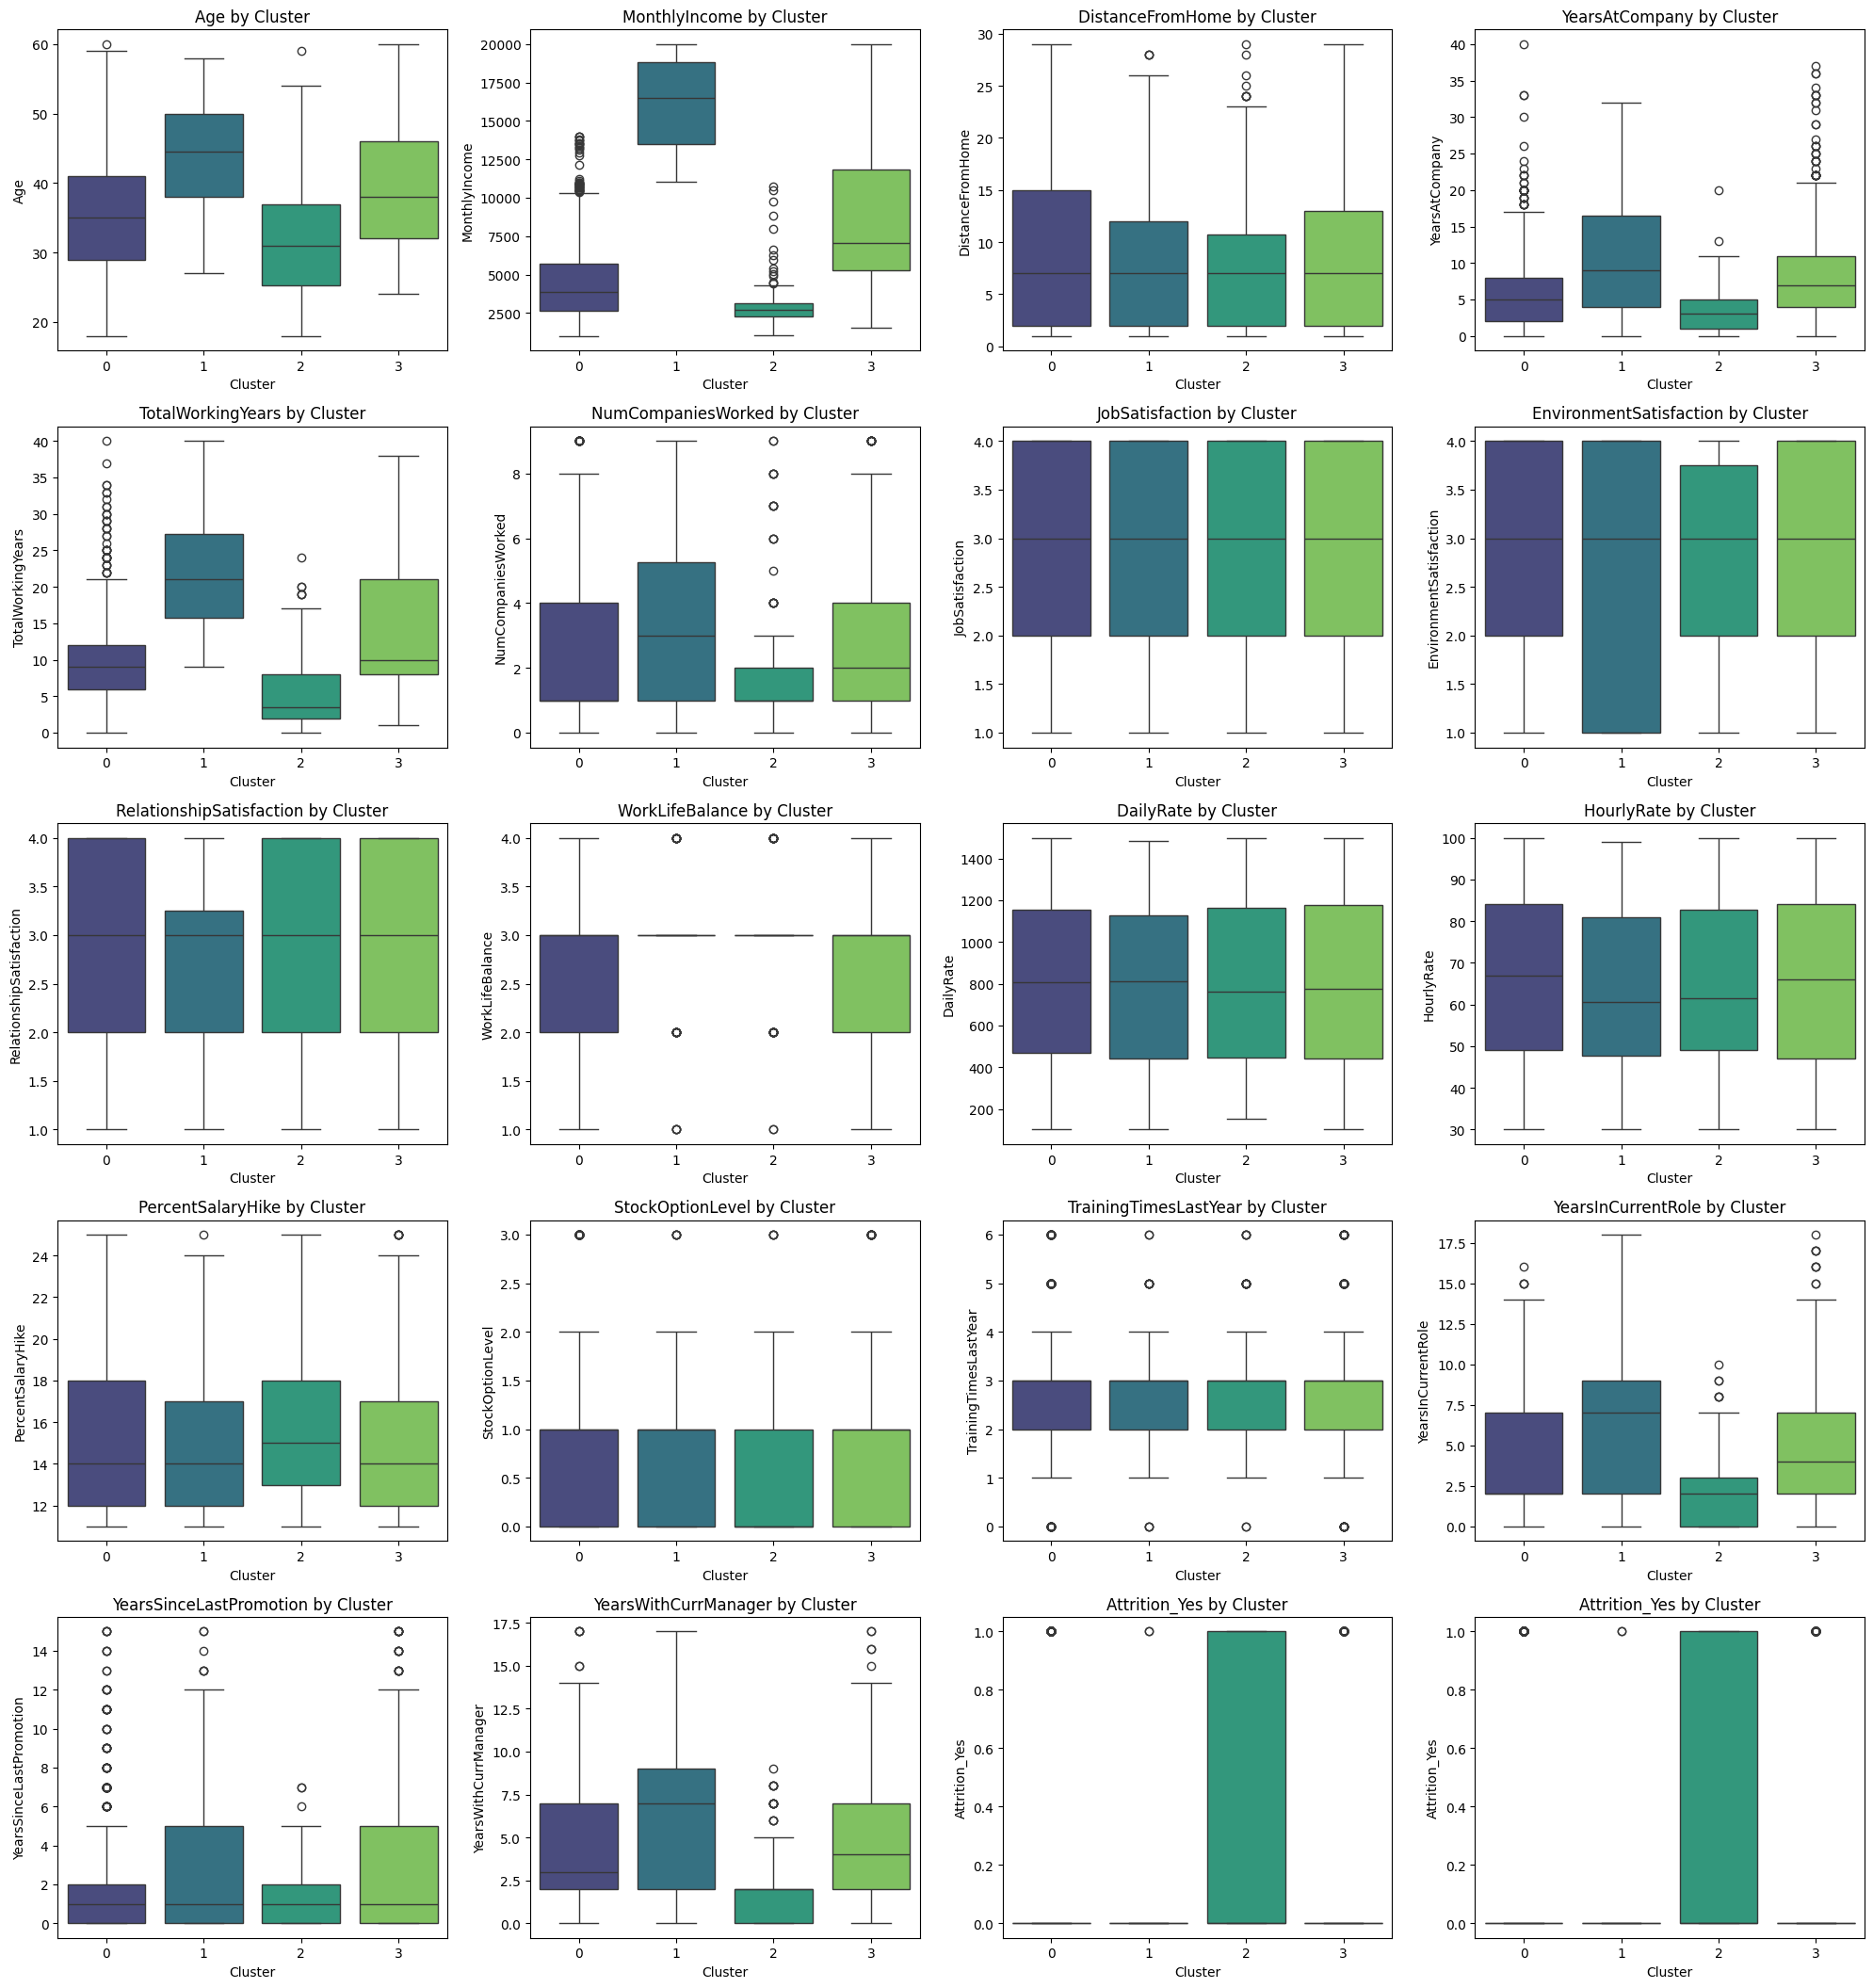


--- 分类特征在各簇中的分布 ---

--- Gender by Cluster ---
Gender     Female      Male
Cluster                    
0        0.389359  0.610641
1        0.412500  0.587500
2        0.429825  0.570175
3        0.409800  0.590200


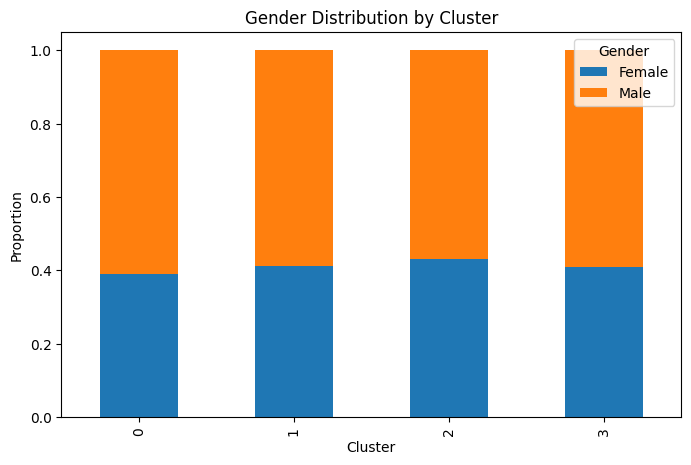


--- Education by Cluster ---
Education         1         2         3         4         5
Cluster                                                    
0          0.123337  0.189843  0.396614  0.264813  0.025393
1          0.087500  0.162500  0.375000  0.287500  0.087500
2          0.201754  0.219298  0.359649  0.210526  0.008772
3          0.084633  0.193764  0.385301  0.293987  0.042316


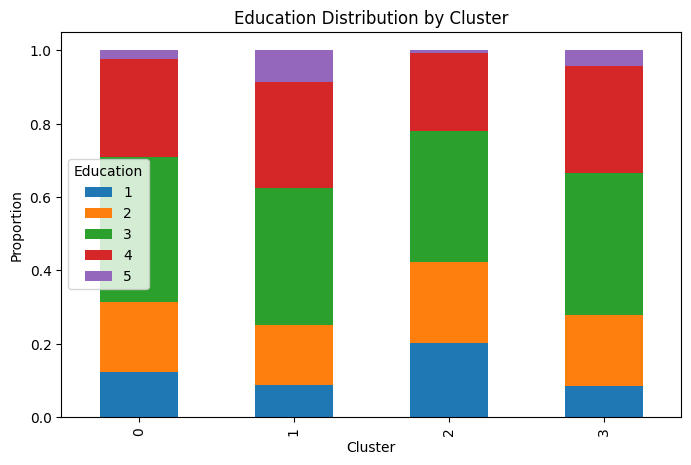


--- EducationField by Cluster ---
EducationField  Human Resources  Life Sciences  Marketing   Medical     Other  \
Cluster                                                                         
0                      0.000000       0.463120   0.000000  0.366385  0.066505   
1                      0.000000       0.450000   0.000000  0.437500  0.050000   
2                      0.000000       0.350877   0.201754  0.254386  0.043860   
3                      0.060134       0.327394   0.302895  0.216036  0.040089   

EducationField  Technical Degree  
Cluster                           
0                       0.103990  
1                       0.062500  
2                       0.149123  
3                       0.053452  


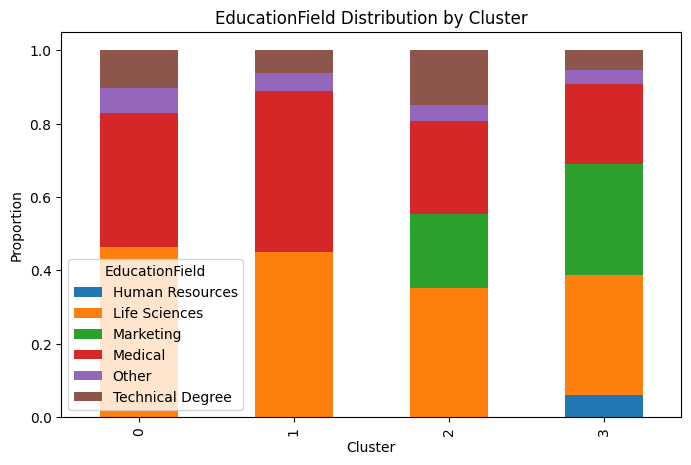


--- MaritalStatus by Cluster ---
MaritalStatus  Divorced   Married    Single
Cluster                                    
0              0.226119  0.442563  0.331318
1              0.287500  0.475000  0.237500
2              0.166667  0.421053  0.412281
3              0.218263  0.492205  0.289532


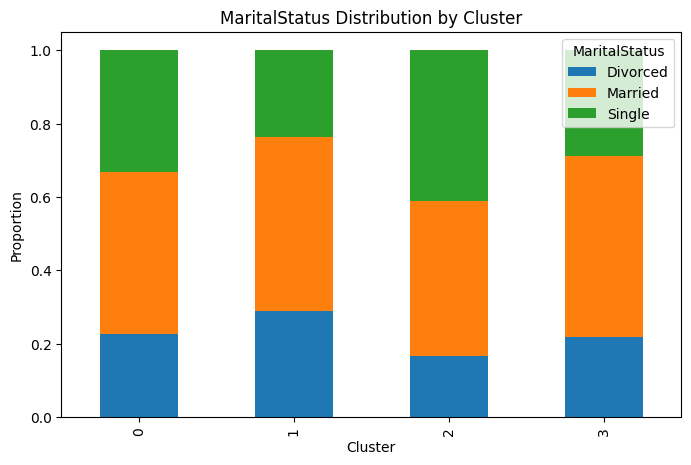


--- JobRole by Cluster ---
JobRole  Healthcare Representative  Human Resources  Laboratory Technician  \
Cluster                                                                      
0                         0.158404         0.000000                0.31318   
1                         0.000000         0.000000                0.00000   
2                         0.000000         0.271930                0.00000   
3                         0.000000         0.046771                0.00000   

JobRole   Manager  Manufacturing Director  Research Director  \
Cluster                                                        
0        0.000000                0.175333                0.0   
1        0.000000                0.000000                1.0   
2        0.000000                0.000000                0.0   
3        0.227171                0.000000                0.0   

JobRole  Research Scientist  Sales Executive  Sales Representative  
Cluster                                          

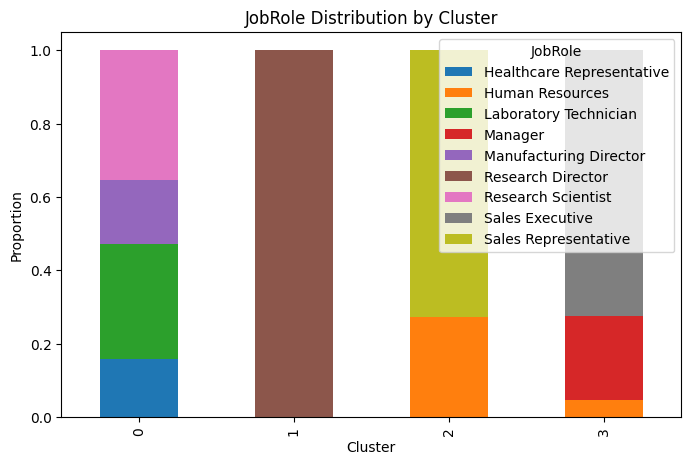


--- Department by Cluster ---
Department  Human Resources  Research & Development     Sales
Cluster                                                      
0                  0.000000                1.000000  0.000000
1                  0.000000                1.000000  0.000000
2                  0.271930                0.000000  0.728070
3                  0.071269                0.120267  0.808463


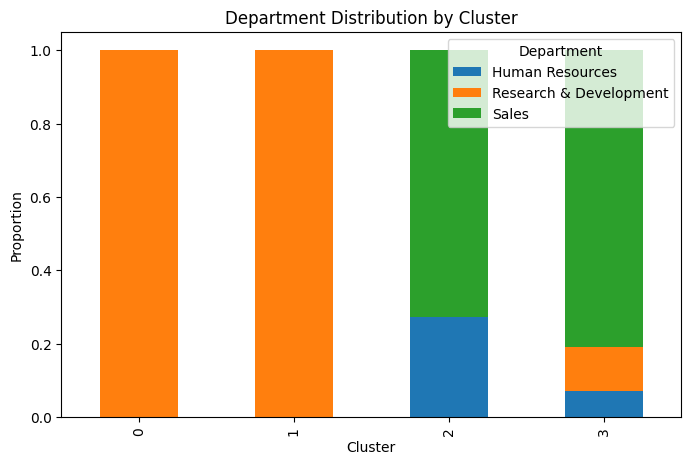


--- BusinessTravel by Cluster ---
BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Cluster                                                     
0                 0.101572           0.193470       0.704958
1                 0.075000           0.150000       0.775000
2                 0.061404           0.236842       0.701754
3                 0.118040           0.173719       0.708241


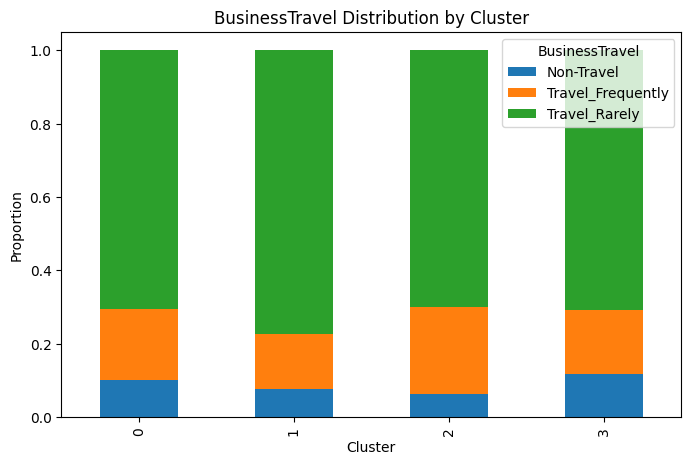


--- OverTime by Cluster ---
OverTime        No       Yes
Cluster                     
0         0.715840  0.284160
1         0.712500  0.287500
2         0.728070  0.271930
3         0.717149  0.282851


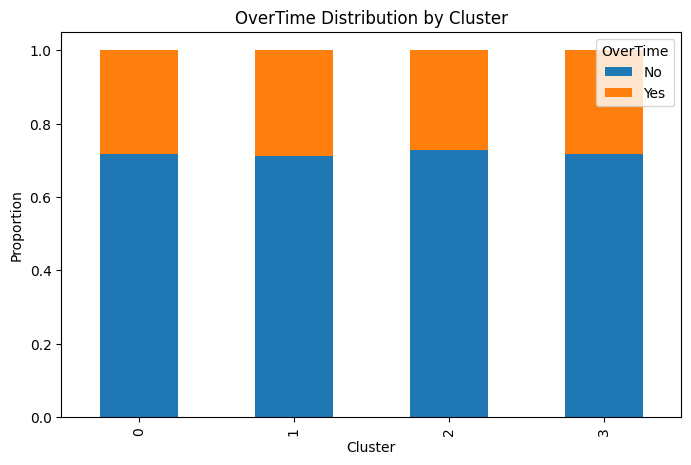

In [40]:
# 对每个聚类进行数值型特征的统计分析（均值）
print("\n每个聚类的平均特征值：")
# 这里我们选择所有数值型列进行均值计算，排除 'Cluster' 列本身
numeric_cols = km_original.select_dtypes(include=['int64', 'float64']).columns.drop('Cluster', errors='ignore')
cluster_summary_numeric = km_original.groupby('Cluster')[numeric_cols].mean()
print(cluster_summary_numeric)
# 可视化关键数值型特征的分布
# 选择一些对业务解读最有价值的特征进行箱线图或小提琴图可视化
# 确保这些特征在 df_original 中存在
features_for_viz_numeric = [
    'Age', 'MonthlyIncome', 'DistanceFromHome', 'YearsAtCompany',
    'TotalWorkingYears', 'NumCompaniesWorked', 'JobSatisfaction',
    'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance',
    'DailyRate', 'HourlyRate', 'PercentSalaryHike', 'StockOptionLevel',
    'TrainingTimesLastYear', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
    'YearsWithCurrManager',
    'Attrition_Yes' # 如果之前没有删除Attrition，这里可以分析其离职率
]
# 过滤掉不存在于 km_original 中的特征，并加入编码后的 'Attrition_Yes'
if 'Attrition' in km_original.columns: # 如果原始数据中包含'Attrition'列
    km_original['Attrition_Yes'] = (km_original['Attrition'] == 'Yes').astype(int)
    features_for_viz_numeric.append('Attrition_Yes')
feature_for_viz_numeric = [f for f in features_for_viz_numeric if f in km_original.columns]
plt.figure(figsize=(20, 25)) # 调整图表大小以容纳更多子图
for i, feature in enumerate(features_for_viz_numeric):
    plt.subplot(6, 4, i + 1) # 调整子图布局以适应特征数量
    sns.boxplot(x='Cluster', y=feature, data=km_original, palette='viridis')
    plt.title(f'{feature} by Cluster', fontsize=12)
    plt.xlabel('Cluster', fontsize=10)
    plt.ylabel(feature, fontsize=10)
plt.tight_layout()
plt.show()


# 对于分类变量，计算每个聚类中分类变量的频率或比例
print("\n--- 分类特征在各簇中的分布 ---")
categorical_features_for_viz = [
    'Gender', 'Education', 'EducationField', 'MaritalStatus', 'JobRole',
    'Department', 'BusinessTravel', 'OverTime'
]

for feature in categorical_features_for_viz:
    if feature in km_original.columns:
        print(f"\n--- {feature} by Cluster ---")
        # 使用 normalize='index' 得到每个簇内部的比例
        print(pd.crosstab(km_original['Cluster'], km_original[feature], normalize='index'))
        # 也可以可视化
        pd.crosstab(km_original['Cluster'], km_original[feature], normalize='index').plot(kind='bar', stacked=True, figsize=(8, 5))
        plt.title(f'{feature} Distribution by Cluster')
        plt.ylabel('Proportion')
        plt.show()

## 4.AHP层次分析


**理解AHP的核心思想与步骤**


AHP将一个复杂的决策问题分解为目标层、准则层（一级指标）和方案层（二级指标），然后通过构建判断矩阵，对同一层次的因素进行两两比较，最终计算出每个因素的权重。



1. 构建层次结构模型

2. 构建判断矩阵： 对同一层次的元素，根据它们对上一层元素的相对重要性进行两两比较。

3. 计算权重向量（一致性检验）： 对判断矩阵进行计算，得出各元素的权重，并进行一致性检验，确保判断的逻辑合理性。

4. 计算组合权重： 将各层次的权重进行组合，得到最底层元素相对于总目标的总权重。

### 4.1 AHP层次结构设计



```
graph TD
    A[识别高离职风险员工] --> B[工作压力]
    A --> C[满意度]
    A --> D[稳定性]
    B --> B1(OverTime)
    B --> B2(WorkLifeBalance)
    C --> C1(JobSatisfaction)
    C --> C2(EnvironmentSatisfaction)
    D --> D1(YearsAtCompany)
    D --> D2(Age)
```

- 目标层： 识别高离职风险员工（A）

- 准则层（一级指标）： 工作压力（B）、满意度（C）、稳定性（D）

- 方案层（二级指标）：

  - 工作压力：加班（OverTime, B1）、工作生活平衡  （WorkLifeBalance, B2）

  - 满意度：工作满意度（JobSatisfaction, C1）、环境 满意度（EnvironmentSatisfaction, C2）

  - 稳定性：在公司年限（YearsAtCompany, D1）、年龄  （Age, D2）

### 4.2 构建判断矩阵与赋值

这是AHP中最主观但也是最关键的一步。需要根据自己的经验、领域知识或咨询专家，对各个因素进行两两比较。我们使用1-9标度法来表示相对重要性：



```
标度      含义

1       同等重要

3       稍微重要

5       明显重要

7       强烈重要

9       极端重要

2,4,6,8     中间值

倒数    比较对象的倒数
```



- 这是主观判断的体现。 赋值将直接影响最终权重。在实际项目中，这通常由一个专家小组共同完成。

- 矩阵是对称的。 如果A比B重要，则B比A重要度是其倒数。


**目标层对准则层的判断矩阵 (A-B/C/D)**


- 认为工作压力对离职风险的影响是明显重要于满意度的 (5)。

- 认为工作压力对离职风险的影响是强烈重要于稳定性的 (7)。

- 认为满意度对离职风险的影响是稍微重要于稳定性的 (3)。

根据这些主观判断，填充矩阵：



```
          工作压力(B)   满意度(C)   稳定性(D)

工作压力(B)       1       5       7

满意度(C)        1/5      1       3

稳定性(D)        1/7      1/3      1
```

**准则层对方案层的判断矩阵**

示例判断理由：

- 我认为加班对工作压力的影响是稍微重要于工作生活平衡的 (3)。



```
          OverTime(B1)      WorkLifeBalance(B2)

OverTime(B1)       1             3

WorkLifeBalance(B2)   1/3             1
```



### 4.3权重计算与一致性检验
AHP的计算过程涉及到矩阵的特征值和特征向量。可以使用Python库来简化这一过程，并进行一致性检验。


 **一致性检验：** AHP要求判断矩阵具有较高的一致性，以确保判断的逻辑合理性。通常通过计算一致性比率 (CR) 来衡量。**当CR小于0.1时，认为判断矩阵通过一致性检验**；否则，需要调整判断矩阵的赋值。


在AHP中，当判断矩阵A是一致矩阵时，其最大特征根 $\lambda_{max}$ 等于矩阵的阶数 n，且其对应的特征向量就是权重向量。然而，在实际应用中，由于主观判断的误差，我们构建的判断矩阵通常是非完全一致的。


特征根法就是找到近似的一致矩阵的最大特征根
$\lambda_{max}$，以及它对应的特征向量 W。这个特征向量经过归一化后，就是我们所求的权重向量。


**计算步骤：**

1. 构建判断矩阵 $A$。

2. 计算矩阵 $A$ 的最大特征值
$\lambda_{max}$ 及其对应的特征向量 $W$。

3. 对特征向量 $W$ 进行归一化，使其元素之和为1，即得到权重向量。

4. 计算一致性指标 ($CI$)：$$CI = \frac{\lambda_{max} - n}{n - 1}$$

5. 计算一致性比率 (CR)：$$CR = \frac{CI}{RI}$$ ($RI$是随机一致性指标)

不同 n 值对应的 RI 值如下表：

| n   | RI   |
| :-- | :--- |
| 1   | 0.00 |
| 2   | 0.00 |
| 3   | 0.58 |
| 4   | 0.90 |
| 5   | 1.12 |
| 6   | 1.24 |
| 7   | 1.32 |
| 8   | 1.41 |
| 9   | 1.45 |
| 10  | 1.49 |

In [ ]:
import numpy as np

def calculate_ahp_weights_eigen(matrix):

  """
  计算判断矩阵的权重向量和一致性指标
  """
  matrix = np.array(matrix,dtype=float)
  n = matrix.shape[0] # 获取矩阵的行数
  # 计算特征值特征向量
  # np.linalg.eig 返回特征值和特征向量
  eigenvalues,eigenvectors = np.linalg.eig(matrix)
  # 找最大特征值和索引
  # 特征值可能是复数，但对于正互反矩阵，最大特征值通常是实数且唯一
  max_eigenvalue_index = np.argmax(eigenvalues.real) #通过 .real，我们只提取每个特征值的实部，舍弃其虚部
  lambda_max = eigenvalues.real[max_eigenvalue_index]

  # 获取对应于最大特征值的特征向量
  # 特征向量可能为负值，需要取绝对值，然后归一化

  weights = eigenvectors[:,max_eigenvalue_index].real
  weights = np.abs(weights) #取绝对值

  weights = weights/np.sum(weights)

  CI = (lambda_max-n)/(n-1)

  RI_values = {
        1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12,
        6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
  }

  """
  从 RI_values 字典中查找当前矩阵阶数 n 对应的随机一致性指标 RI 值。
  如果 n 值不在字典的键中（例如 n 大于10），
  它会安全地返回 0

  """
  RI = RI_values.get(n,0)


  CR = CI / RI if RI != 0 else 0

  return weights,CI,CR,lambda_max

print("--- 1. 目标层对准则层的判断矩阵 (使用特征根法) ---")
matrix_A = [
    [1, 5, 7],
    [1/5, 1, 3],
    [1/7, 1/3, 1]
]

weights_A, CI_A, CR_A, lambda_max_A = calculate_ahp_weights_eigen(matrix_A)
print(f"权重 (工作压力, 满意度, 稳定性): {weights_A}")
print(f"最大特征值 (lambda_max): {lambda_max_A:.4f}")
print(f"CI: {CI_A:.4f}, CR: {CR_A:.4f}")


print("\n--- 2. 工作压力（B）对加班（B1）和工作生活平衡（B2）的判断矩阵 (使用特征根法) ---")
matrix_B = [
    [1, 3],
    [1/3, 1]
]

weights_B, CI_B, CR_B, lambda_max_B = calculate_ahp_weights_eigen(matrix_B)
print(f"权重 (OverTime, WorkLifeBalance): {weights_B}")
print(f"最大特征值 (lambda_max): {lambda_max_B:.4f}")
print(f"CI: {CI_B:.4f}, CR: {CR_B:.4f}")

print("\n--- 3. 满意度（C）对工作满意度（C1）和环境满意度（C2）的判断矩阵 (使用特征根法) ---")
matrix_C = [
    [1, 2],
    [1/2, 1]
]
weights_C, CI_C, CR_C, lambda_max_C = calculate_ahp_weights_eigen(matrix_C)
print(f"权重 (JobSatisfaction, EnvironmentSatisfaction): {weights_C}")
print(f"最大特征值 (lambda_max): {lambda_max_C:.4f}")
print(f"CI: {CI_C:.4f}, CR: {CR_C:.4f}")

print("\n--- 4. 稳定性（D）对在公司年限（D1）和年龄（D2）的判断矩阵 (使用特征根法) ---")
matrix_D = [
    [1, 1/2],
    [2, 1]
]
weights_D, CI_D, CR_D, lambda_max_D = calculate_ahp_weights_eigen(matrix_D)
print(f"权重 (YearsAtCompany, Age): {weights_D}")
print(f"最大特征值 (lambda_max): {lambda_max_D:.4f}")
print(f"CI: {CI_D:.4f}, CR: {CR_D:.4f}")

--- 1. 目标层对准则层的判断矩阵 (使用特征根法) ---
权重 (工作压力, 满意度, 稳定性): [0.73064467 0.1883941  0.08096123]
最大特征值 (lambda_max): 3.0649
CI: 0.0324, CR: 0.0559

--- 2. 工作压力（B）对加班（B1）和工作生活平衡（B2）的判断矩阵 (使用特征根法) ---
权重 (OverTime, WorkLifeBalance): [0.75 0.25]
最大特征值 (lambda_max): 2.0000
CI: 0.0000, CR: 0.0000

--- 3. 满意度（C）对工作满意度（C1）和环境满意度（C2）的判断矩阵 (使用特征根法) ---
权重 (JobSatisfaction, EnvironmentSatisfaction): [0.66666667 0.33333333]
最大特征值 (lambda_max): 2.0000
CI: 0.0000, CR: 0.0000

--- 4. 稳定性（D）对在公司年限（D1）和年龄（D2）的判断矩阵 (使用特征根法) ---
权重 (YearsAtCompany, Age): [0.33333333 0.66666667]
最大特征值 (lambda_max): 2.0000
CI: 0.0000, CR: 0.0000


### 4.4计算组合权重
在所有判断矩阵都通过一致性检验后，我们将各层次的权重进行组合，得到最底层因素相对于总目标（识别高离职风险员工）的总权重。



In [ ]:
# 准则层（一级指标）的权重
W_B_C_D = weights_A

# 方案层（二级指标）的权重
W_B1_B2 = weights_B
W_C1_C2 = weights_C
W_D1_D2 = weights_D

# 计算最终的组合权重
# OverTime (B1) 的总权重 = 工作压力 (B) 的权重 * OverTime (B1) 在工作压力下的权重
weight_OverTime = W_B_C_D[0] * W_B1_B2[0]
weight_WorkLifeBalance = W_B_C_D[0] * W_B1_B2[1]

weight_JobSatisfaction = W_B_C_D[1] * W_C1_C2[0]
weight_EnvironmentSatisfaction = W_B_C_D[1] * W_C1_C2[1]

weight_YearsAtCompany = W_B_C_D[2] * W_D1_D2[0]
weight_Age = W_B_C_D[2] * W_D1_D2[1]

final_weights = {
    "OverTime": weight_OverTime,
    "WorkLifeBalance": weight_WorkLifeBalance,
    "JobSatisfaction": weight_JobSatisfaction,
    "EnvironmentSatisfaction": weight_EnvironmentSatisfaction,
    "YearsAtCompany": weight_YearsAtCompany,
    "Age": weight_Age
}
# 按权重降序排序
sorted_weights = sorted(final_weights.items(), key=lambda item: item[1], reverse=True)

print("\n--- 最终离职风险因素权重（AHP组合权重）---")
for factor, weight in sorted_weights:
    print(f"{factor}: {weight:.4f}")




--- 最终离职风险因素权重（AHP组合权重）---
OverTime: 0.5480
WorkLifeBalance: 0.1827
JobSatisfaction: 0.1256
EnvironmentSatisfaction: 0.0628
Age: 0.0540
YearsAtCompany: 0.0270


## 5.TOPSIS

topsis:(Technique for Order Preference by Similarity to Ideal Solution) 优劣解距离法

TOPSIS 的核心思想是：**“好的”方案应该与正理想解（所有指标都最优的虚拟方案）最接近，同时与负理想解（所有指标都最差的虚拟方案）最远离。**

**TOPSIS 实施步骤**


1. 确定评价指标和原始数据： 明确用于评估员工离职风险的具体指标。

2. 数据正向化处理： 将所有指标统一为“数值越大越好”或“数值越小越好”的类型。对于离职风险，我们通常希望**“风险越高，指标值越大”**。

3. 数据规范化（标准化）： 消除不同指标量纲和数量级的影响，使数据可比较。

4. 构建加权规范化矩阵： 结合各指标的权重（可以沿用之前AHP计算出的权重）。

5. 确定正理想解和负理想解： 在加权规范化矩阵中，找出每个指标的最优值和最劣值。

6. 计算到正、负理想解的距离： 使用欧氏距离计算每个员工到正理想解和负理想解的距离。

7. 计算相对接近度（TOPSIS得分）： 衡量每个员工与正理想解的接近程度。

8. 排序并识别高风险员工： 根据相对接近度对员工进行排序，得分越高表示离职风险越高。

### 5.1 确定评价指标和原始数据

我们沿用AHP中识别出的离职风险二级指标：

- 工作压力： OverTime (加班), WorkLifeBalance (工作生活平衡)

- 满意度： JobSatisfaction (工作满意度), EnvironmentSatisfaction (环境满意度)

- 稳定性： YearsAtCompany (在公司年限), Age (年龄)

我们需要从原始的IBM离职分析数据集中提取这些指标的数据，并将其与AHP计算出的权重结合。

**重要考虑：指标类型和正向化处理**

在TOPSIS中，所有指标必须统一方向。对于“高离职风险”这个目标，我们希望指标值越大，风险越高。

- 正向指标（效益型）： 值越大越好（如 OverTime：加班越多，离职风险可能越高）。

- 负向指标（成本型）： 值越小越好（如 JobSatisfaction：满意度越低，离职风险越高，所以需要反向处理）。

| 评价指标            | 含义                 | 数据类型   | 指标类型（对离职风险而言） | 处理方式（统一为越大越好） |
| :------------------ | :------------------- | :--------- | :------------------------- | :------------------------- |
| `OverTime`          | 加班                 | Categorical | 正向（Yes表示加班多，风险高）| 独热编码后，`OverTime_Yes` 为1 |
| `WorkLifeBalance`   | 工作生活平衡         | Ordinal (1-4) | 负向（1：差，4：好）        | `5 - WorkLifeBalance`      |
| `JobSatisfaction`   | 工作满意度           | Ordinal (1-4) | 负向（1：低，4：高）        | `5 - JobSatisfaction`      |
| `EnvironmentSatisfaction` | 环境满意度         | Ordinal (1-4) | 负向（1：低，4：高）        | `5 - EnvironmentSatisfaction` |
| `YearsAtCompany`    | 在公司年限           | Numerical | 负向（年限越长，风险越低） | `MaxYears - YearsAtCompany` |
| `Age`               | 年龄                 | Numerical | 负向（年龄越大，风险越低） | `MaxAge - Age`             |

注意：

- OverTime是分类变量（Yes/No），独热编码后 OverTime_Yes 为1表示加班，0表示不加班，这已经是正向的。

- 对于其他负向指标，我们通过 Max_Value - Original_Value 的方式进行正向化。这里的 Max_Value 取决于该指标的最大可能值（例如，对于1-4的满意度，Max_Value可以是5）。对于年龄和公司年限，我们需要找到数据集中的实际最大值。

### 5.2 数据准备和正向化

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/IBM_HR_Analytics.csv')
df_original = df.copy()


# 定义用于TOPSIS的指标列
# 注意：'OverTime' 是分类变量，需要独热编码
topsis_features = [
    'OverTime', 'WorkLifeBalance', 'JobSatisfaction',
    'EnvironmentSatisfaction', 'YearsAtCompany', 'Age'
]

# 提取相关数据，并保留EmployeeNumber以便后续排名

df_topsis = df_original[['EmployeeNumber']+topsis_features].copy()

# --- 2.1 正向化处理 ---

# OverTime: 'Yes' -> 1, 'No' -> 0 (已经是正向，因为Yes表示加班，风险高)

df_topsis['OverTime_Yes'] = (df_topsis['OverTime'] == 'Yes').astype(int)

df_topsis = df_topsis.drop(columns = ['OverTime'])

# 更新 topsis_features 列表

topsis_features[topsis_features.index('OverTime')] = 'OverTime_Yes'
# WorkLifeBalance, JobSatisfaction, EnvironmentSatisfaction (1-4，1最差，4最好)
# 转换为：5 - 原值，使值越小越好转化为值越大越好
df_topsis['WorkLifeBalance'] = 5 - df_topsis['WorkLifeBalance']
df_topsis['JobSatisfaction'] = 5 - df_topsis['JobSatisfaction']
df_topsis['EnvironmentSatisfaction'] = 5 - df_topsis['EnvironmentSatisfaction']

# YearsAtCompany, Age (数值，值越大越稳定，风险越低)
# 转换为：最大值 - 原值，使值越小越好转化为值越大越好
max_years_at_company = df_topsis['YearsAtCompany'].max()
max_age = df_topsis['Age'].max()

df_topsis['YearsAtCompany'] = max_years_at_company + 1 - df_topsis['YearsAtCompany'] # +1确保值不为0，且不与最大值重叠
df_topsis['Age'] = max_age + 1 - df_topsis['Age'] # +1确保值不为0

print("正向化处理后的数据（部分）：")
print(df_topsis.head())


# 存储员工ID
employee_ids = df_topsis['EmployeeNumber']
# 提取用于TOPSIS计算的特征数据
data_matrix = df_topsis[topsis_features].values

正向化处理后的数据（部分）：
   EmployeeNumber  WorkLifeBalance  JobSatisfaction  EnvironmentSatisfaction  \
0               1                4                1                        3   
1               2                2                3                        2   
2               4                2                2                        1   
3               5                2                2                        1   
4               7                2                3                        4   

   YearsAtCompany  Age  OverTime_Yes  
0              35   20             1  
1              31   12             0  
2              41   24             1  
3              33   28             1  
4              39   34             0  


### 5.3 数据规范化（标准化）

$$r_{ij} = \frac{x_{ij}}{\sqrt{\sum_{i=1}^{m} x_{ij}^2}}$$

In [ ]:
# 计算每个指标（列）的平方和的开方
norm_factors = np.sqrt(np.sum(data_matrix**2, axis=0))

# 规范化决策矩阵
normalized_matrix = data_matrix / norm_factors

print("\n规范化后的决策矩阵（部分）：")
print(pd.DataFrame(normalized_matrix, columns=topsis_features).head())


规范化后的决策矩阵（部分）：
   OverTime_Yes  WorkLifeBalance  JobSatisfaction  EnvironmentSatisfaction  \
0      0.049029         0.044442          0.01033                 0.030967   
1      0.000000         0.022221          0.03099                 0.020645   
2      0.049029         0.022221          0.02066                 0.010322   
3      0.049029         0.022221          0.02066                 0.010322   
4      0.000000         0.022221          0.03099                 0.041290   

   YearsAtCompany       Age  
0        0.026430  0.020258  
1        0.023409  0.012155  
2        0.030961  0.024309  
3        0.024920  0.028361  
4        0.029451  0.034438  


### 5.4 构建加权规范化矩阵
TOPSIS需要为每个指标赋予权重。我们将使用之前AHP计算出的权重。

In [ ]:
# 确保这些权重与 topsis_features 的顺序一致
# 这里使用之前AHP示例计算的权重
ahp_weights = {
        "OverTime_Yes": 0.5480,
        "WorkLifeBalance": 0.1827,
        "JobSatisfaction": 0.1256,
        "EnvironmentSatisfaction": 0.0628,
        "YearsAtCompany": 0.0270,
        "Age": 0.0540
}

# 根据 topsis_features 的顺序创建权重向量
weights_vector = np.array([ahp_weights[feature] for feature in topsis_features])
print("\nTOPSIS使用的权重向量:", weights_vector)

# 构建加权规范化矩阵

weighted_normalized_matrix = normalized_matrix * weights_vector

print("\n加权规范化矩阵（部分）：")
print(pd.DataFrame(weighted_normalized_matrix, columns=topsis_features).head())


TOPSIS使用的权重向量: [0.548  0.1827 0.1256 0.0628 0.027  0.054 ]

加权规范化矩阵（部分）：
   OverTime_Yes  WorkLifeBalance  JobSatisfaction  EnvironmentSatisfaction  \
0      0.026868         0.008119         0.001297                 0.001945   
1      0.000000         0.004060         0.003892                 0.001296   
2      0.026868         0.004060         0.002595                 0.000648   
3      0.026868         0.004060         0.002595                 0.000648   
4      0.000000         0.004060         0.003892                 0.002593   

   YearsAtCompany       Age  
0        0.000714  0.001094  
1        0.000632  0.000656  
2        0.000836  0.001313  
3        0.000673  0.001531  
4        0.000795  0.001860  


### 5.5 确定正理想解和负理想解

- 正理想解（Positive Ideal Solution, A+）： 每个指标的最佳值（对于我们正向化后的指标，就是每一列的最大值）。

- 负理想解（Negative Ideal Solution, A−）： 每个指标的最差值（对于我们正向化后的指标，就是每一列的最小值）。


In [ ]:
# 确定正理想解 (A_plus) 和负理想解 (A_minus)
# 由于我们已经正向化处理，所以所有指标都是“越大越好”
A_plus = np.max(weighted_normalized_matrix, axis=0)
A_minus = np.min(weighted_normalized_matrix, axis=0)

print("\n正理想解 (A_plus):", A_plus)
print("负理想解 (A_minus):", A_minus)


正理想解 (A_plus): [0.02686791 0.0081195  0.00518987 0.002593   0.00083594 0.00235194]
负理想解 (A_minus): [0.00000000e+00 2.02987470e-03 1.29746804e-03 6.48249970e-04
 2.03888765e-05 5.46963413e-05]


### 5.6 计算到正、负理想解的距离
使用欧氏距离来计算每个员工的方案到正理想解和负理想解的距离。

公式：

- 到正理想解的距离
$$D_i^+ = \sqrt{\sum_{j=1}^{n} (v_{ij} - A_j^+)^2}$$

  解释：
  
  $D_i^+$: 表示第 $i$ 个方案到正理想解的距离。
  
  $v_{ij}$: 表示加权规范化矩阵中第 $i$ 个方案的 第 $j$ 个指标值。
  
  $A_j^+$: 表示第 $j$ 个指标在正理想解中的值。
  
  $n$: 表示指标的总数量。


- 到负理想解的距离


$$D_i^- = \sqrt{\sum_{j=1}^{n} (v_{ij} - A_j^-)^2}$$

In [ ]:
# 计算每个员工到正理想解的距离 D_plus
D_plus = np.sqrt(np.sum((weighted_normalized_matrix - A_plus)**2, axis=1))

# 计算每个员工到负理想解的距离 D_minus
D_minus = np.sqrt(np.sum((weighted_normalized_matrix - A_minus)**2, axis=1))

print("\n每个员工到正理想解的距离 (D_plus, 部分):")
print(D_plus[:5])
print("\n每个员工到负理想解的距离 (D_minus, 部分):")
print(D_minus[:5])


每个员工到正理想解的距离 (D_plus, 部分):
[0.0041435  0.02728822 0.0052988  0.0052628  0.02720834]

每个员工到负理想解的距离 (D_minus, 部分):
[0.02760814 0.00346561 0.02701733 0.02702397 0.00430051]


### 5.7 计算相对接近度（TOPSIS得分）
相对接近度 $C_i$ 用于衡量每个员工与正理想解的接近程度，同时远离负理想解。这个值就是我们的TOPSIS得分。

公式：

$$C_i = \frac{D_i^-}{D_i^+ + D_i^-}$$

C_i 值介于 0 到 1 之间。对于离职风险排序，我们希望 C_i 值越大越好，表示员工的风险越高。

In [ ]:
# 计算相对接近度 (C_i) - TOPSIS得分
# 避免分母为0的情况
C_i = D_minus / (D_plus + D_minus)
# 处理可能出现的 D_plus + D_minus == 0 的情况（理论上在非零数据中很少出现，但稳健性考虑）
C_i = np.nan_to_num(C_i, nan=0.0) # 将NaN替换为0

print("\n每个员工的TOPSIS得分 (C_i, 部分):")
print(C_i[:5])


每个员工的TOPSIS得分 (C_i, 部分):
[0.86950277 0.11268868 0.83603228 0.8369983  0.13648573]


### 5.8 排序并输出 TOP 10 高风险员工ID
最后，我们将TOPSIS得分与员工ID关联起来，并按得分降序排序，输出TOP 10的高风险员工ID。

In [ ]:
# 创建包含员工ID和TOPSIS得分的DataFrame
topsis_results = pd.DataFrame({
    'EmployeeNumber': employee_ids,
    'TOPSIS_Score': C_i
})

# 按TOPSIS_Score降序排序，得分越高表示离职风险越高
ranked_employees = topsis_results.sort_values(by='TOPSIS_Score', ascending=False)

print("\n--- 员工离职风险排名 TOP 10 ---")
print(ranked_employees.head(10))



--- 员工离职风险排名 TOP 10 ---
      EmployeeNumber  TOPSIS_Score
1171            1649      0.958594
725             1010      0.930892
889             1244      0.929360
1060            1494      0.927455
1255            1758      0.926431
336              454      0.925445
669              932      0.924991
730             1015      0.924911
195              267      0.920506
1188            1669      0.916719


## 6.题目

将数据集拆分为**训练集**和**测试集**，训练集进行数据模型搭建，并使用测试集对结果进行验证，并且选择合适的方法**评估模型**。

**问题一：**找到影响员工月收入的关键因素，预测员工月收入

**问题二：**将员工分成不同类别，并分别描述各类别员工特性，以及他们是否有较高离职率。

**问题三：**找到影响员工离职的几个关键因素，最终输出离职风险最高的20名员工。